# Lab 2. Unsupervised Learning. 

### Part 1: Recommendation system for movies based on content
### Part 2: Somoclu - Self Organizing Maps 



# Team Info

- Members:
  - Antoniadis Panagiotis - 03115009
  - Masouris Athanasios - 03115189
  - Bazotis Nikolaos - 03115739

In [0]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

     |████████████████████████████████| 1.5MB 33.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 20.1 MB 19 kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.17.5
    Uninstalling numpy-1.17.5:
      Successfully uninstalled numpy-1.17.5


Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.25.3)
     |████████████████████████████████| 1.5 MB 37.5 MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449906 sha256=9147b7b80d1c56087ab8677ea5cc7653c320036b4ae104a6bee61edeb28bd6ce
  Stored in directory: /root/.cache/pip/wheels/e3/c9/b0/ed26a73ef75a53145820825afa8e2d2c9b30fe9f6c10cd3202
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.1)
Requirement already up-to-date: joblib in /usr/local/lib/python3.6/dist-packages (0.14.1)


# Loading the data

In [0]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from joblib import Parallel, delayed

For our exercise we are going to use a subset of the [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/) dataset. This dataset contains 42,306 movie plot summaries extracted from Wikipedia and aligned metadata extracted from Freebase, including the movie title, one or more labels about to genre and a short summary. 

In [0]:
dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

We will use a subset containing 5.000 movies based on our team seed number.


In [0]:
# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 16

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1RRoiOjhD0JB3l4oHNFOmPUqZHDphIdwL"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

- **Titles** array: movie titles (i.g., 'Sid and Nancy')
- **Categories** array: genres (i.g., '"Tragedy", "Musical", "Drama", ...'), we can see that the type format is String List seperated by commas. Each of these strings is a category.
- **Catbins** array: includes the genres in a **one hot encoding** format. ([More info](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f))
- **Summaries** array and **corpus** list: they both include the short summaries of the movies in a string format. The corpus list has the summary on a string list format. (i.g., *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*)
- **ID**: we are going to use the row index of each movie as its ID. (i.g., if we want to print the corpus of the movie with `ID=99` we will use `print(corpus[99])`.

In [0]:
ID = 99
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['The Avengers']
['"Science Fiction",  "Action"']
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

# Part 1. Implementation of the movie recommendations system based on the content
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

We are going to implement a content based [recommendation system](https://en.wikipedia.org/wiki/Recommender_system) for movies. The purpose of this system is to recommend movies that might interest the user. Recommender systems usually make use of either or both collaborative filtering and content-based filtering. Collaborative filtering is based on the assumption that people who agreed in the past will agree in the future, and that they will like similar kinds of items as they liked in the past while Content-based filtering methods are based on a description of the item and a profile of the user's preferences.

Our content-based recommendation system will focus on the corpus of each movie.


## Transformation to TFIDF

The first step is to transform the corpus to a tf-idf representation.

In [0]:
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

The [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) that call here **is not optimized**. The tuning of the parameters for the vectorizer **will have a significant impact on the quality of the recommendations** and it's different for every dataset. In addition, the values that we will choose for the parameters will have an effect on the **dimensionality of the dataset**, which will then impact the **training time**, especially for the second part of this lab.


In [0]:
print(corpus_tf_idf.shape)
n,m = corpus_tf_idf.shape

(5000, 48490)


## Implementation of the recommendation system

`def content_recommender(target_movie, max_recommendations, corpus_tf_idf)`

 This function takes three input arguments:\
`target_movie`: ID of the movie that we want recommendations for,\
`max_recommendations`: maximum number of recommendations,\
`corpus_tf_idf`: the corpus vectorizer


then we calculate the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) of the target movies' corpus with the rest of the corpuses. Then based on this metric, we sort an array of movie IDs in descending order. 

Output:\
It prints the following format for both the target movie and the recommendations:

Id, title, summary, categories

(The first recommended movie, #1, is the one that was calculated as the closest to the target movie)


Εισάγουμε όλες τις απαραίτητες βιβλιοθήκες.

In [0]:
import nltk
from nltk.corpus import stopwords
import string 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import names
from tqdm import tqdm, tqdm_notebook

nltk.download('stopwords') # κατεβάζουμε ένα αρχείο που έχει stopwords στα αγγλικά
nltk.download('punkt') # χρειάζεται για το tokenizer
nltk.download('wordnet')
nltk.download('rslp')
nltk.download('names')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


True

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

UNDERLINE = '\033[4m'
END = '\033[0m'

def content_recommender(target_movie, max_recommendations, corpus_tf_idf):
  # Get the vector of the target movie
  target_tf_idf = corpus_tf_idf[target_movie]
  # Compute the similarities 
  similarities = np.zeros(n)
  for i in range(n):
    current_sim = cosine_similarity(target_tf_idf, corpus_tf_idf[i])
    similarities[i] = current_sim

  # Sort the movies in descending order of similarity
  sorted_idx = np.argsort(similarities)[::-1]

  # Output details of the target movie
  print(UNDERLINE+"Target movie"+END)
  print("Id: %d" %target_movie)
  print("Title: %s" %titles[target_movie][0])
  print("Summary: %s" %corpus[target_movie])
  print("Categories: %s" %(",".join(categories[target_movie])))

  # Verify that the closest vector is the target vector itself
  assert sorted_idx[0] == target_movie

  # Output details of the recommended movies
  for rec in range(1,max_recommendations+1):
    rec_id = sorted_idx[rec]
    print(UNDERLINE+"Recommended movie "+ str(rec) +END)
    print("Id: %d" %rec_id)
    print("Title: %s" %titles[rec_id][0])
    print("Summary: %s" %corpus[rec_id])
    print("Categories: %s" %(",".join(categories[rec_id])))


## Optimization

In this section we are going to preprocess the corpuses and optimize the `TfidfVectorizer` by tuning its parameters. 




### Preprocessing the corpuses

Before we apply the TfidfVectorizer, we will preprocess the corpuses in order to remove unwanted strings and characters from our corpuses:
1. Removing punctuations
2. Removing names
3. Applying stemming



In [0]:
def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words
      
def parallel_preprocess_corpus(doc): 
  words = nltk.word_tokenize(doc.lower())
  # Remove punctuation and names
  filtered_words = [word for word in words if (word not in list(string.punctuation)) or (word[0].upper()+word[1:] not in names.words('male.txt') + names.words('female.txt'))]
  # Further filtering for punctuation
  filtered_words = thorough_filter(filtered_words)
  # Perform stemming
  porter_stemmer = PorterStemmer()
  ret_words = [porter_stemmer.stem(word) for word in filtered_words]

  return ' '.join(ret_words)
  
def common_words(doc1, doc2):
  words1 = nltk.word_tokenize(doc1.lower())
  words2 = nltk.word_tokenize(doc2.lower())
  commons = set()
  for word1 in words1:
    for word2 in words2:
      if word1 == word2:
        commons.add(word1)
      elif word1.startswith(word2) or word2.startswith(word1):
          commons.add(word1)
          commons.add(word2)
  return commons

In [0]:
corpus_processed = Parallel(n_jobs=-1)(delayed(parallel_preprocess_corpus)(doc) for doc in tqdm_notebook(corpus, desc="Parallel preprocessing of corpus"))

We are going to dump the preprocessed corpus to a pkl file.

In [0]:
joblib.dump(corpus_processed, 'corpus_processed.pkl') 

['corpus_processed.pkl']

In [0]:
corpus_processed = joblib.load('corpus_processed.pkl')

### Initial recommendations

Below we are going to see some initial recommendations of our system for different target movies.

In [0]:
content_recommender(4, 3, corpus_tf_idf)

Target movie
Id: 4
Title: Star Trek: Insurrection
Summary: While observing the peaceful Ba'ku people on their planet, Lieutenant Commander Data  appears to malfunction, revealing the hidden presence of the joint Federation and Son'a task force to the Ba'ku. Admiral Matthew Dougherty requests the help of the starship USS Enterprise-E to help capture or disable Data. Admiral Dougherty's allies, the Son'a, are a decrepit race using various medical techniques to cheat death, repeated face lift surgeries giving them a mummified appearance. After stopping Data, USS Enterprise captain Jean-Luc Picard becomes suspicious of Dougherty's insistence that the Enterprise is no longer needed, and his crew investigates the cause for Data's malfunction. They discover that the Ba'ku are technologically advanced but have opted to live in harmony with nature. Due to unique radiation or "metaphasic particles" in their world's rings, they are essentially immortal. The Enterprise crew also begins to experien

In [0]:
print("Common words between Target movie and Recommended movie 1:\n %s" %(", ".join(common_words(corpus[1724], corpus[4]))))
print("Common words between Target movie and Recommended movie 2:\n %s" %(", ".join(common_words(corpus[4735], corpus[4]))))
print("Common words between Target movie and Recommended movie 3:\n %s" %(", ".join(common_words(corpus[4071], corpus[4]))))

Common words between Target movie and Recommended movie 1:
 becomes, admiral, is, altered, best, returning, anij, as, discover, by, heroin, will, have, mom, all, over, that, out, helped, starship, or, manages, you, return, leaves, who, insists, too, downtrodden, an, informs, investigates, killing, finds, sends, begins, again, death, believes, ;, young, assaults, but, s, forgive, starts, orders, take, start, ships, healing, then, instruction, attempted, it, from, forge, in, asks, between, while, whole, la, announces, several, lives, william, others, beating, the, officers, using, often, science, with, up, beaten, through, onto, a, before, peacefully, lactate, lives.http, acquire, order, attempt, arranges, head, injecting, systems, no, man, herself, self-destruct, surgeries, killed, later, only, notices, after, '', gives, not, apartment, slowly, inside, advanced, off, so, become, since, actions, takes, tells, follows, for, benefits, use, accounts, trying, activate, he, give, attacking, a

In [0]:
content_recommender(8, 3, corpus_tf_idf)

Target movie
Id: 8
Title: The Oxford Murders
Summary:  Martin , a US student at the University of Oxford, wants Arthur Seldom  as his thesis supervisor. He idolises Seldom and has learned all about him. He takes accommodation in Oxford at the house of Mrs. Eagleton , an old friend of Seldom. Also in the house is her daughter, Beth , who is her full time caregiver — which she resents bitterly — and a musician by occupation. In a public lecture, Seldom quotes Wittgenstein's Tractatus to deny the possibility of absolute truth. Hoping to impress his idol, Martin disputes this, asserting his faith in the absolute truth of mathematics: "I believe in the number pi." Seldom humiliates him, ridiculing his arguments and making him look foolish in front of the audience. Disillusioned, Martin decides to abandon his studies and goes to his office to collect his belongings. There, he encounters his office-mate, a bitter mathematician Podorov , who also failed to become a student of Seldom's. Martin 

In [0]:
print("Common words between Target movie and Recommended movie 1:\n %s" %(", ".join(common_words(corpus[4827], corpus[8]))))
print("Common words between Target movie and Recommended movie 2:\n %s" %(", ".join(common_words(corpus[3211], corpus[8]))))
print("Common words between Target movie and Recommended movie 3:\n %s" %(", ".join(common_words(corpus[4175], corpus[8]))))

Common words between Target movie and Recommended movie 1:
 andrew, becomes, instead, receives, two, agents, disgust, is, friend, as, theorem, had, advantage, by, away, irritant, normal, impress, shell-shocked, '86, absolute, army, have, all, that, over, out, adorable, arriving, invented, helping, or, inspiration, night, intelligence, who, alcoholic, point, toddler, arrived, friends, insulting, intended, an, meet, attempts, more, visiting, does, finds, killer, killing, death, do, ;, acting, thesis, take, whose, then, taken, standoff, topic, therefore, indeed, it, in, donors, adults, from, enter, between, while, note, receive, office, interlocking, the, accommodation, with, organ, house, visit, i, stands, suggests, theorize, order, audience, invitation, attempt, address, head, ammunition, no, man, martin, heisenberg, works, accident, killed, later, schoolchildren, tense, only, life, alive, agree, after, fortuitous, '', not, runs, gives, whom, inside, albeit, so, off, become, debilitatin

In [0]:
content_recommender(12, 3, corpus_tf_idf)

Target movie
Id: 12
Title: Dead Man
Summary: William Blake , an accountant from Cleveland, Ohio, rides by train to the frontier company town of Machine to assume a promised job as a bookkeeper in the town's Dickinson metal works. During the trip, a Fireman  warns Blake against the enterprise while passengers shoot buffalo from the train windows. Arriving in town, Blake discovers that his position has already been filled, and is driven from the workplace at gunpoint by John Dickinson , the ferocious owner of the company. Jobless and without money or prospects, Blake meets Thel Russell , a former prostitute who sells paper flowers. He lets her take him home. Thel's ex-boyfriend Charlie  surprises them in bed and shoots Blake, accidentally killing Thel when she tries to shield Blake with her body. A wounded Blake shoots and kills Charlie with Thel's gun before climbing dazedly out the window and fleeing Machine on a stolen pinto. Company-owner Dickinson, the father of Charlie, hires three

In [0]:
print("Common words between Target movie and Recommended movie 1:\n %s" %(", ".join(common_words(corpus[2351], corpus[12]))))
print("Common words between Target movie and Recommended movie 2:\n %s" %(", ".join(common_words(corpus[353], corpus[12]))))
print("Common words between Target movie and Recommended movie 3:\n %s" %(", ".join(common_words(corpus[3304], corpus[12]))))

Common words between Target movie and Recommended movie 1:
 is, asking, states, as, american, by, away, will, windows, state, out, camp, alimony, hires, somehow, arriving, attempting, or, any, heart, who, too, an, attempts, purposes, sends, again, arrested, but, money, take, whose, nobody, can, then, win, from, in, horse, arrest, asks, while, organizes, william, office, the, abandoning, with, assume, question, decide, america, head, dead, blake, no, answer, only, after, '', gives, agree, whom, so, off, purpose, announcing, another, sell, sells, inherited, campaign, about, takes, including, for, without, tries, give, he, at, remove, been, himself, thel, ,, ., them, her, their, candidate, has, on, abduction, deadlocked, into, former, meets, back, him, window, there, send, against, decides, his, accountant, hire, accidentally, already, are, although, they, alone, awakens, russell, when, of, quest, to, 's, arranging, town, sheriff, ``, she, and, son, a, both
Common words between Target mov

### Parameter tuning

#### 1st optimization: Preprocessed corpus
We are going to use the preprocessed corpus.

In [0]:
vectorizer_pre_corp = TfidfVectorizer()
vectorizer_pre_corp.fit(corpus_processed)
corpus_tf_idf_pre_corp = vectorizer_pre_corp.transform(corpus_processed)
print(corpus_tf_idf_pre_corp.shape)

(5000, 35515)


In [0]:
content_recommender(4, 5, corpus_tf_idf_pre_corp)

Target movie
Id: 4
Title: Star Trek: Insurrection
Summary: While observing the peaceful Ba'ku people on their planet, Lieutenant Commander Data  appears to malfunction, revealing the hidden presence of the joint Federation and Son'a task force to the Ba'ku. Admiral Matthew Dougherty requests the help of the starship USS Enterprise-E to help capture or disable Data. Admiral Dougherty's allies, the Son'a, are a decrepit race using various medical techniques to cheat death, repeated face lift surgeries giving them a mummified appearance. After stopping Data, USS Enterprise captain Jean-Luc Picard becomes suspicious of Dougherty's insistence that the Enterprise is no longer needed, and his crew investigates the cause for Data's malfunction. They discover that the Ba'ku are technologically advanced but have opted to live in harmony with nature. Due to unique radiation or "metaphasic particles" in their world's rings, they are essentially immortal. The Enterprise crew also begins to experien

In [0]:
print("Common words between Target movie and Recommended movie 1:\n %s" %(", ".join(common_words(corpus[1724], corpus[4]))))
print("Common words between Target movie and Recommended movie 2:\n %s" %(", ".join(common_words(corpus[3287], corpus[4]))))
print("Common words between Target movie and Recommended movie 3:\n %s" %(", ".join(common_words(corpus[4735], corpus[4]))))
print("Common words between Target movie and Recommended movie 4:\n %s" %(", ".join(common_words(corpus[4071], corpus[4]))))
print("Common words between Target movie and Recommended movie 5:\n %s" %(", ".join(common_words(corpus[4685], corpus[4]))))

Common words between Target movie and Recommended movie 1:
 becomes, admiral, is, altered, best, returning, anij, as, discover, by, heroin, will, have, mom, all, over, that, out, helped, starship, or, manages, you, return, leaves, who, insists, too, downtrodden, an, informs, investigates, killing, finds, sends, begins, again, death, believes, ;, young, assaults, but, s, forgive, starts, orders, take, start, ships, healing, then, instruction, attempted, it, from, forge, in, asks, between, while, whole, la, announces, several, lives, william, others, beating, the, officers, using, often, science, with, up, beaten, through, onto, a, before, peacefully, lactate, lives.http, acquire, order, attempt, arranges, head, injecting, systems, no, man, herself, self-destruct, surgeries, killed, later, only, notices, after, '', gives, not, apartment, slowly, inside, advanced, off, so, become, since, actions, takes, tells, follows, for, benefits, use, accounts, trying, activate, he, give, attacking, a

#### 2nd optimization: Stop words
We are going to use the parameter `stop_words`, since these words won't help the quality of our systems' recommendations. 

In [0]:
vectorizer_stop = TfidfVectorizer(stop_words='english')
vectorizer_stop.fit(corpus_processed)
corpus_tf_idf_stop = vectorizer_stop.transform(corpus_processed)
print(corpus_tf_idf_stop.shape)

(5000, 35276)


In [0]:
content_recommender(4, 5, corpus_tf_idf_stop)

Target movie
Id: 4
Title: Star Trek: Insurrection
Summary: While observing the peaceful Ba'ku people on their planet, Lieutenant Commander Data  appears to malfunction, revealing the hidden presence of the joint Federation and Son'a task force to the Ba'ku. Admiral Matthew Dougherty requests the help of the starship USS Enterprise-E to help capture or disable Data. Admiral Dougherty's allies, the Son'a, are a decrepit race using various medical techniques to cheat death, repeated face lift surgeries giving them a mummified appearance. After stopping Data, USS Enterprise captain Jean-Luc Picard becomes suspicious of Dougherty's insistence that the Enterprise is no longer needed, and his crew investigates the cause for Data's malfunction. They discover that the Ba'ku are technologically advanced but have opted to live in harmony with nature. Due to unique radiation or "metaphasic particles" in their world's rings, they are essentially immortal. The Enterprise crew also begins to experien

In [0]:
print("Common words between Target movie and Recommended movie 1:\n %s" %(", ".join(common_words(corpus[3287], corpus[4]))))
print("Common words between Target movie and Recommended movie 2:\n %s" %(", ".join(common_words(corpus[2352], corpus[4]))))
print("Common words between Target movie and Recommended movie 3:\n %s" %(", ".join(common_words(corpus[1849], corpus[4]))))
print("Common words between Target movie and Recommended movie 4:\n %s" %(", ".join(common_words(corpus[4271], corpus[4]))))
print("Common words between Target movie and Recommended movie 5:\n %s" %(", ".join(common_words(corpus[503], corpus[4]))))

Common words between Target movie and Recommended movie 1:
 becomes, starships, needed, captured, admiral, is, altered, returning, aboard, anij, as, discover, by, exiled, alien, away, indecipherable, will, probes, captain, have, all, that, out, arriving, learns, starship, or, return, leaves, who, approaching, mission, insists, an, enterprise, attempts, investigates, finds, sends, begins, task, uss, but, beamed, ;, forgive, ships, take, discovered, exile, aircraft, attempted, it, from, forge, in, transport, approach, until, between, while, la, formula, commander, william, the, officers, using, with, collecting, through, onto, sending, a, before, accompanied, acquire, hearing, attempt, arranges, head, no, aluminum, enterprise-e, answer, only, after, orbit, '', collect, not, gives, probe, advanced, answered, actions, takes, officer, around, for, benefits, use, accounts, plan, activate, he, give, discovers, at, uses, been, leave, insistence, allies, find, able, artificial, tasks, ,, ., fac

We can already see an improvement in the performance of our system. All of the above recommendations belong to the "Science Fiction" category and their corpuses contain similar key-words to our target movies' corpus.

In [0]:
content_recommender(8, 5, corpus_tf_idf)

Target movie
Id: 8
Title: The Oxford Murders
Summary:  Martin , a US student at the University of Oxford, wants Arthur Seldom  as his thesis supervisor. He idolises Seldom and has learned all about him. He takes accommodation in Oxford at the house of Mrs. Eagleton , an old friend of Seldom. Also in the house is her daughter, Beth , who is her full time caregiver — which she resents bitterly — and a musician by occupation. In a public lecture, Seldom quotes Wittgenstein's Tractatus to deny the possibility of absolute truth. Hoping to impress his idol, Martin disputes this, asserting his faith in the absolute truth of mathematics: "I believe in the number pi." Seldom humiliates him, ridiculing his arguments and making him look foolish in front of the audience. Disillusioned, Martin decides to abandon his studies and goes to his office to collect his belongings. There, he encounters his office-mate, a bitter mathematician Podorov , who also failed to become a student of Seldom's. Martin 

In [0]:
print("Common words between Target movie and Recommended movie 1:\n %s" %(", ".join(common_words(corpus[4827], corpus[8]))))
print("Common words between Target movie and Recommended movie 2:\n %s" %(", ".join(common_words(corpus[3211], corpus[8]))))
print("Common words between Target movie and Recommended movie 3:\n %s" %(", ".join(common_words(corpus[4175], corpus[8]))))
print("Common words between Target movie and Recommended movie 4:\n %s" %(", ".join(common_words(corpus[2508], corpus[8]))))
print("Common words between Target movie and Recommended movie 5:\n %s" %(", ".join(common_words(corpus[4735], corpus[8]))))

Common words between Target movie and Recommended movie 1:
 andrew, becomes, instead, receives, two, agents, disgust, is, friend, as, theorem, had, advantage, by, away, irritant, normal, impress, shell-shocked, '86, absolute, army, have, all, that, over, out, adorable, arriving, invented, helping, or, inspiration, night, intelligence, who, alcoholic, point, toddler, arrived, friends, insulting, intended, an, meet, attempts, more, visiting, does, finds, killer, killing, death, do, ;, acting, thesis, take, whose, then, taken, standoff, topic, therefore, indeed, it, in, donors, adults, from, enter, between, while, note, receive, office, interlocking, the, accommodation, with, organ, house, visit, i, stands, suggests, theorize, order, audience, invitation, attempt, address, head, ammunition, no, man, martin, heisenberg, works, accident, killed, later, schoolchildren, tense, only, life, alive, agree, after, fortuitous, '', not, runs, gives, whom, inside, albeit, so, off, become, debilitatin

In [0]:
content_recommender(12, 5, corpus_tf_idf)

Target movie
Id: 12
Title: Dead Man
Summary: William Blake , an accountant from Cleveland, Ohio, rides by train to the frontier company town of Machine to assume a promised job as a bookkeeper in the town's Dickinson metal works. During the trip, a Fireman  warns Blake against the enterprise while passengers shoot buffalo from the train windows. Arriving in town, Blake discovers that his position has already been filled, and is driven from the workplace at gunpoint by John Dickinson , the ferocious owner of the company. Jobless and without money or prospects, Blake meets Thel Russell , a former prostitute who sells paper flowers. He lets her take him home. Thel's ex-boyfriend Charlie  surprises them in bed and shoots Blake, accidentally killing Thel when she tries to shield Blake with her body. A wounded Blake shoots and kills Charlie with Thel's gun before climbing dazedly out the window and fleeing Machine on a stolen pinto. Company-owner Dickinson, the father of Charlie, hires three

In [0]:
print("Common words between Target movie and Recommended movie 1:\n %s" %(", ".join(common_words(corpus[2351], corpus[12]))))
print("Common words between Target movie and Recommended movie 2:\n %s" %(", ".join(common_words(corpus[353], corpus[12]))))
print("Common words between Target movie and Recommended movie 3:\n %s" %(", ".join(common_words(corpus[3304], corpus[12]))))
print("Common words between Target movie and Recommended movie 4:\n %s" %(", ".join(common_words(corpus[2160], corpus[12]))))
print("Common words between Target movie and Recommended movie 5:\n %s" %(", ".join(common_words(corpus[4116], corpus[12]))))

Common words between Target movie and Recommended movie 1:
 is, asking, states, as, american, by, away, will, windows, state, out, camp, alimony, hires, somehow, arriving, attempting, or, any, heart, who, too, an, attempts, purposes, sends, again, arrested, but, money, take, whose, nobody, can, then, win, from, in, horse, arrest, asks, while, organizes, william, office, the, abandoning, with, assume, question, decide, america, head, dead, blake, no, answer, only, after, '', gives, agree, whom, so, off, purpose, announcing, another, sell, sells, inherited, campaign, about, takes, including, for, without, tries, give, he, at, remove, been, himself, thel, ,, ., them, her, their, candidate, has, on, abduction, deadlocked, into, former, meets, back, him, window, there, send, against, decides, his, accountant, hire, accidentally, already, are, although, they, alone, awakens, russell, when, of, quest, to, 's, arranging, town, sheriff, ``, she, and, son, a, both
Common words between Target mov

#### 3rd optimization: Max_df 
Using `max_df` parameter. A big df value indicates that this term appears in many corpuses, which means that its probably a corpus-specific stop word.

In [0]:
vectorizer_stop_maxdf = TfidfVectorizer(stop_words='english', max_df=0.1)
vectorizer_stop_maxdf.fit(corpus_processed)
corpus_tf_idf_stop_maxdf = vectorizer_stop_maxdf.transform(corpus_processed)
print(corpus_tf_idf_stop_maxdf.shape)

(5000, 35130)


In [0]:
content_recommender(4, 5, corpus_tf_idf_stop_maxdf)

Target movie
Id: 4
Title: Star Trek: Insurrection
Summary: While observing the peaceful Ba'ku people on their planet, Lieutenant Commander Data  appears to malfunction, revealing the hidden presence of the joint Federation and Son'a task force to the Ba'ku. Admiral Matthew Dougherty requests the help of the starship USS Enterprise-E to help capture or disable Data. Admiral Dougherty's allies, the Son'a, are a decrepit race using various medical techniques to cheat death, repeated face lift surgeries giving them a mummified appearance. After stopping Data, USS Enterprise captain Jean-Luc Picard becomes suspicious of Dougherty's insistence that the Enterprise is no longer needed, and his crew investigates the cause for Data's malfunction. They discover that the Ba'ku are technologically advanced but have opted to live in harmony with nature. Due to unique radiation or "metaphasic particles" in their world's rings, they are essentially immortal. The Enterprise crew also begins to experien

In [0]:
print("Common words between Target movie and Recommended movie 1:\n %s" %(", ".join(common_words(corpus[3287], corpus[12]))))
print("Common words between Target movie and Recommended movie 2:\n %s" %(", ".join(common_words(corpus[1849], corpus[12]))))
print("Common words between Target movie and Recommended movie 3:\n %s" %(", ".join(common_words(corpus[4271], corpus[12]))))
print("Common words between Target movie and Recommended movie 4:\n %s" %(", ".join(common_words(corpus[2352], corpus[12]))))
print("Common words between Target movie and Recommended movie 5:\n %s" %(", ".join(common_words(corpus[503], corpus[12]))))

Common words between Target movie and Recommended movie 1:
 some, captured, admiral, is, aboard, call, as, frontier, american, by, discover, away, alien, injuries, indecipherable, will, all, that, out, arriving, attempting, learns, somehow, or, return, leaves, who, approaching, mission, insists, too, an, enterprise, attempts, indian, finds, sends, again, but, take, cry, whose, recovering, aircraft, from, hunt, in, approach, while, travel, formula, william, the, officers, with, assume, warns, through, wild, before, accompanied, hearing, attempt, america, head, aluminum, answer, only, after, orbit, '', gives, whom, answered, announcing, takes, about, interview, missionary, officer, around, bed, for, without, beach, give, he, at, discovers, been, returned, stolen, himself, continued, find, ,, thel, ., face, them, ship, accomplish, once, theft, calling, their, on, song, abduction, into, former, most, back, front, him, institute, be, learn, continue, against, clouds, behind, his, includes, 

As we can see, there were not many corpus-specific stop words. We could decrease the `max_df` value, but we think its better to use the `min_df` parameter for further tuning.

#### 4th optimization: Min_df
Using `min_df` parameter. We are going to remove terms with df value lower than a threshold. These terms appear rarely in our corpuses, so they won't help our recommendations.

In [0]:
vectorizer_stop_maxdf_mindf = TfidfVectorizer(stop_words='english', max_df=0.1, min_df=6)
vectorizer_stop_maxdf_mindf.fit(corpus_processed)
corpus_tf_idf_stop_maxdf_mindf = vectorizer_stop_maxdf_mindf.transform(corpus_processed)
print(corpus_tf_idf_stop_maxdf_mindf.shape)

(5000, 8085)


In [0]:
content_recommender(4, 5, corpus_tf_idf_stop_maxdf_mindf)

Target movie
Id: 4
Title: Star Trek: Insurrection
Summary: While observing the peaceful Ba'ku people on their planet, Lieutenant Commander Data  appears to malfunction, revealing the hidden presence of the joint Federation and Son'a task force to the Ba'ku. Admiral Matthew Dougherty requests the help of the starship USS Enterprise-E to help capture or disable Data. Admiral Dougherty's allies, the Son'a, are a decrepit race using various medical techniques to cheat death, repeated face lift surgeries giving them a mummified appearance. After stopping Data, USS Enterprise captain Jean-Luc Picard becomes suspicious of Dougherty's insistence that the Enterprise is no longer needed, and his crew investigates the cause for Data's malfunction. They discover that the Ba'ku are technologically advanced but have opted to live in harmony with nature. Due to unique radiation or "metaphasic particles" in their world's rings, they are essentially immortal. The Enterprise crew also begins to experien

In [0]:
print("Common words between Target movie and Recommended movie 1:\n %s" %(", ".join(common_words(corpus[3287], corpus[4]))))
print("Common words between Target movie and Recommended movie 2:\n %s" %(", ".join(common_words(corpus[4271], corpus[4]))))
print("Common words between Target movie and Recommended movie 3:\n %s" %(", ".join(common_words(corpus[2352], corpus[4]))))
print("Common words between Target movie and Recommended movie 4:\n %s" %(", ".join(common_words(corpus[84], corpus[4]))))
print("Common words between Target movie and Recommended movie 5:\n %s" %(", ".join(common_words(corpus[3600], corpus[4]))))

Common words between Target movie and Recommended movie 1:
 becomes, starships, needed, captured, admiral, is, altered, returning, aboard, anij, as, discover, by, exiled, alien, away, indecipherable, will, probes, captain, have, all, that, out, arriving, learns, starship, or, return, leaves, who, approaching, mission, insists, an, enterprise, attempts, investigates, finds, sends, begins, task, uss, but, beamed, ;, forgive, ships, take, discovered, exile, aircraft, attempted, it, from, forge, in, transport, approach, until, between, while, la, formula, commander, william, the, officers, using, with, collecting, through, onto, sending, a, before, accompanied, acquire, hearing, attempt, arranges, head, no, aluminum, enterprise-e, answer, only, after, orbit, '', collect, not, gives, probe, advanced, answered, actions, takes, officer, around, for, benefits, use, accounts, plan, activate, he, give, discovers, at, uses, been, leave, insistence, allies, find, able, artificial, tasks, ,, ., fac

As we can see the `min_df` parameter lead to a big dimensionality reduction. However, the quality of our recommendations improved.

#### 5th optimization: Ngrams
Using `ngram_range` parameter. By default we use unigrams. However we can use bigrams or trigrams to enrich our vectorizer with more features, although we expect a significant increase in the dimensionality.

In [0]:
vectorizer_stop_maxdf_mindf_ngram = TfidfVectorizer(stop_words='english', max_df=0.1, min_df=6, ngram_range=(1,2))
vectorizer_stop_maxdf_mindf_ngram.fit(corpus_processed)
corpus_tf_idf_stop_maxdf_mindf_ngram = vectorizer_stop_maxdf_mindf_ngram.transform(corpus_processed)
print(corpus_tf_idf_stop_maxdf_mindf_ngram.shape)

(5000, 15613)


In [0]:
content_recommender(4, 5, corpus_tf_idf_stop_maxdf_mindf_ngram)

Target movie
Id: 4
Title: Star Trek: Insurrection
Summary: While observing the peaceful Ba'ku people on their planet, Lieutenant Commander Data  appears to malfunction, revealing the hidden presence of the joint Federation and Son'a task force to the Ba'ku. Admiral Matthew Dougherty requests the help of the starship USS Enterprise-E to help capture or disable Data. Admiral Dougherty's allies, the Son'a, are a decrepit race using various medical techniques to cheat death, repeated face lift surgeries giving them a mummified appearance. After stopping Data, USS Enterprise captain Jean-Luc Picard becomes suspicious of Dougherty's insistence that the Enterprise is no longer needed, and his crew investigates the cause for Data's malfunction. They discover that the Ba'ku are technologically advanced but have opted to live in harmony with nature. Due to unique radiation or "metaphasic particles" in their world's rings, they are essentially immortal. The Enterprise crew also begins to experien

In [0]:
print("Common words between Target movie and Recommended movie 1:\n %s" %(", ".join(common_words(corpus[881], corpus[4]))))
print("Common words between Target movie and Recommended movie 2:\n %s" %(", ".join(common_words(corpus[3287], corpus[4]))))
print("Common words between Target movie and Recommended movie 3:\n %s" %(", ".join(common_words(corpus[4271], corpus[4]))))
print("Common words between Target movie and Recommended movie 4:\n %s" %(", ".join(common_words(corpus[84], corpus[4]))))
print("Common words between Target movie and Recommended movie 5:\n %s" %(", ".join(common_words(corpus[2352], corpus[4]))))

Common words between Target movie and Recommended movie 1:
 becomes, eyes, met, admiral, continues, two, accuse, is, altered, meeting, returning, aide, anij, as, by, will, all, master, that, out, over, starship, heart, return, who, insists, among, intended, an, meet, started, behold, investigates, associates, adapts, begins, do, uss, but, believes, young, masterminds, s, heartbeat, ships, forgive, take, start, healing, independent, attempted, it, from, forge, in, until, aung, between, while, lady, la, request, lives, william, inflicted, the, officers, attention, advancement, using, science, with, would, onto, towards, a, refuse, before, acquire, attempt, arranges, systems, dooming, no, herself, self-destruct, surgeries, only, after, beat, not, slowly, whom, advanced, since, actions, follows, together, for, immediately, acceptance, benefits, use, beauty, accounts, initial, trying, plan, activate, he, at, uses, village, forced, upon, allies, insistence, himself, withheld, metaphasic, fol

As expected we have increased dimensions. However the quality of our recommendations didn't improve significantly. Therefore, if we want to use this vectorizer, we have to reduce the dimensions by tuning the `max_df` and `min_df` parameters.

In [0]:
vectorizer_stop_maxdf_mindf_ngram = TfidfVectorizer(stop_words='english', max_df=0.05, min_df=12, ngram_range=(1,2))
vectorizer_stop_maxdf_mindf_ngram.fit(corpus_processed)
corpus_tf_idf_stop_maxdf_mindf_ngram = vectorizer_stop_maxdf_mindf_ngram.transform(corpus_processed)
print(corpus_tf_idf_stop_maxdf_mindf_ngram.shape)

(5000, 7238)


In [0]:
content_recommender(4, 5, corpus_tf_idf_stop_maxdf_mindf_ngram)

Target movie
Id: 4
Title: Star Trek: Insurrection
Summary: While observing the peaceful Ba'ku people on their planet, Lieutenant Commander Data  appears to malfunction, revealing the hidden presence of the joint Federation and Son'a task force to the Ba'ku. Admiral Matthew Dougherty requests the help of the starship USS Enterprise-E to help capture or disable Data. Admiral Dougherty's allies, the Son'a, are a decrepit race using various medical techniques to cheat death, repeated face lift surgeries giving them a mummified appearance. After stopping Data, USS Enterprise captain Jean-Luc Picard becomes suspicious of Dougherty's insistence that the Enterprise is no longer needed, and his crew investigates the cause for Data's malfunction. They discover that the Ba'ku are technologically advanced but have opted to live in harmony with nature. Due to unique radiation or "metaphasic particles" in their world's rings, they are essentially immortal. The Enterprise crew also begins to experien

We can see that the quality of our system is worse than before. Therefore we are going to use the vectorizer from step 4 of the optimization.

#### Final vectorizer

In [0]:
corpus_tf_idf = corpus_tf_idf_stop_maxdf_mindf

joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 

['corpus_tf_idf.pkl']

In [0]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

### Examples of movie recommendations

__10 examples (IDs) from our dataset.__

1.Common content: All of the movies below are about  life and battles in space.

In [0]:
content_recommender(4, 5, corpus_tf_idf)

Target movie
Id: 4
Title: Star Trek: Insurrection
Summary: While observing the peaceful Ba'ku people on their planet, Lieutenant Commander Data  appears to malfunction, revealing the hidden presence of the joint Federation and Son'a task force to the Ba'ku. Admiral Matthew Dougherty requests the help of the starship USS Enterprise-E to help capture or disable Data. Admiral Dougherty's allies, the Son'a, are a decrepit race using various medical techniques to cheat death, repeated face lift surgeries giving them a mummified appearance. After stopping Data, USS Enterprise captain Jean-Luc Picard becomes suspicious of Dougherty's insistence that the Enterprise is no longer needed, and his crew investigates the cause for Data's malfunction. They discover that the Ba'ku are technologically advanced but have opted to live in harmony with nature. Due to unique radiation or "metaphasic particles" in their world's rings, they are essentially immortal. The Enterprise crew also begins to experien

2. Common content: All of the movies below are about a man trying to solve a crime or a mystery.

In [0]:
content_recommender(8, 5, corpus_tf_idf)

Target movie
Id: 8
Title: The Oxford Murders
Summary:  Martin , a US student at the University of Oxford, wants Arthur Seldom  as his thesis supervisor. He idolises Seldom and has learned all about him. He takes accommodation in Oxford at the house of Mrs. Eagleton , an old friend of Seldom. Also in the house is her daughter, Beth , who is her full time caregiver — which she resents bitterly — and a musician by occupation. In a public lecture, Seldom quotes Wittgenstein's Tractatus to deny the possibility of absolute truth. Hoping to impress his idol, Martin disputes this, asserting his faith in the absolute truth of mathematics: "I believe in the number pi." Seldom humiliates him, ridiculing his arguments and making him look foolish in front of the audience. Disillusioned, Martin decides to abandon his studies and goes to his office to collect his belongings. There, he encounters his office-mate, a bitter mathematician Podorov , who also failed to become a student of Seldom's. Martin 

3. Common content: In all of the movies below, the protagonist is a member of a royal family. The plot of each movie unfolds arround his/her romantic life.

In [0]:
content_recommender(14, 5, corpus_tf_idf)

Target movie
Id: 14
Title: 14 Blades
Summary: During the late Ming Dynasty, the imperial court is plagued by corruption as eunuchs usurp state power and the reigning emperor is incompetent. The Jinyi Wei  are the government's secret police, trained in clandestine combat since childhood, they are in charge of conducting missions to ensure peace and stability within the empire. They have the authority to prosecute anyone deemed as an enemy of the state and they devote their lives and lethal prowess to serving the emperor only. When the organization was first founded, the Jinyi Wei took orders directly from the emperor, but now they are under the control of the eunuchs. The eunuch chief Jia Jingzhong is plotting with an exiled noble, Prince Qing, to rebel against the emperor and seize power. Jia Jingzhong orders Qinglong, the Jinyi Wei leader, to kill the Imperial Councilor Zhao Shenyan and take Zhao's safebox, which supposedly contains a list of names of traitors. However, Qinglong disco

4. Common content: All of the movies below are "Drama/Horror" films. The plot of each movie is about the personal relationships of the protagonist.

In [0]:
content_recommender(25, 5, corpus_tf_idf)

Target movie
Id: 25
Title: Avanim
Summary: Michale is a woman in her mid-30s, married with a young son and working in her father's Tel Aviv accounting firm serving religious institutions. She divides her time between her child, her husband, her work and the man with whom she is having an affair. When Michale learns of the sudden death of her lover, her life is shattered.
Categories: "Drama",  "Indie",  "World cinema"
Recommended movie 1
Id: 1817
Title: Packing the Monkeys, Again!
Summary: Packing the Monkeys, Again! is story about love couple, which live in small rented apartment. Nebojša is a journalist who works to much and he asks Jelena to do everything what all traditional Montenegrian women does. Jelana studies literature and she is suspicious for Nebojša having an affair. Of course, owners of their apartment are coming in their lives and bringing their problems to house of Nebojša and Jelena - Nata, Dragica's and Dragoljub's daughter is a problematic child. But, most interesting

5. Common content: All of the movies below are about war scenes or crimes commited in the past.

In [0]:
content_recommender(110, 5, corpus_tf_idf)

Target movie
Id: 110
Title: The Desert Rats
Summary: In mid-April 1941, during World War II, German Field Marshal Erwin Rommel  and his Afrika Korps have driven the British Army into headlong retreat across North Africa toward Egypt and the vital Suez Canal. Standing in Rommel's way is Tobruk, a constant threat to his supply lines. The 9th Australian Division are asked to hold the port for two months, at which time they are to be relieved. The defending Allied general ([[Robert Douglas  chooses English Captain "Tammy" MacRoberts , an experienced field officer, to take command of a company of newly-arrived, green Australian troops. The no-nonsense MacRoberts is disliked by the undisciplined Australians. He is surprised to see in their ranks his former schoolmaster, Tom Bartlett . Barlett, an alcoholic, later explains that after being dismissed from his job in England due to his drinking, he went to Australia and joined the army while intoxicated. MacRoberts offers to transfer him to a s

6. Common content: All of the movies below are war films. As we can see the first three recommendations are specifically about World War 2 stories that take place in Germany.

In [0]:
content_recommender(180, 5, corpus_tf_idf)

Target movie
Id: 180
Title: Flashback
Summary: Heinz Prulier  is a German soldier stationed as a sniper overlooking his own army from a tree. When he falls asleep, his troops are gone and he is left alone to defend the incoming enemy invasion. Flashbacks recall his wartime experiences and his transition from a human being into a sadistic murderer and rapist. He encounters a prostitute and a giggling girl in this violent feature that reveals the deterioration of human values in the face of the grim realities of war.
Categories: "Drama",  "War film"
Recommended movie 1
Id: 2196
Title: Silent Night
Summary: A German mother , who had already lost her eldest son in the Battle of Stalingrad and whose husband is a cook serving in the German army, and her son are seeking refuge in a cabin near the front lines in the Ardennes forests region of western Europe. They are invaded by three American soldiers and then soon after three German soldiers, and after much resistance the mother manages to co

7. Common content: All of the movies below are about the Stooges family and their adventures.

In [0]:
content_recommender(497, 5, corpus_tf_idf)

Target movie
Id: 497
Title: Dutiful But Dumb
Summary: The Stooges are "Click, Clack and Cluck", paparazzi-like photographers working for Whack Magazine  who continue to grate at their weary boss . To get them out of his hair, he sends them to Vulgaria for their next job, knowing full well that taking pictures in Vulgaria is against the law, leading to execution. The inept trio are caught once they set foot on Vulgarian soil. As the firing squad is setting up, Curly requests one last smoke, leading to him pulling out a cigar the length of a hero sandwich. The wait puts everyone to sleep, and enables the boys to escape. As they try to avoid their captors, they end up in a local cafe, in which Curly pits his wits against a strong drink, and then a defiant oyster in his stew. When the oyster works Curly's last nerve he pulls out his gun and fires at it repeatedly. This gets the attention of the guards who promptly capture the Stooges and carry them off, upside down, on the bayonets of thei

8. Common content: The story of each of the movies below unfolds in a small poor village and it regards the dramatic situations that its characters endure in their lives.

In [0]:
content_recommender(1335, 5, corpus_tf_idf)

Target movie
Id: 1335
Title: 16 Vayathinile
Summary: This film revolves around a 16-year-old girl, Mayil , filled with ambitions of becoming a teacher. She is an attractive, intelligent woman living in a small society and experiences ripe love when sees the new veterinarian who has come to visit. Many are impressed by this charming young fellow who has entered the village. He seems to be a wealthy, prosperous man and soon develops a relationship with Mayil. Mayil, who is deeply in love, sacrifices her opportunity to study in the teaching college course to spend time with him. But his intentions are not pure and he dumps Mayil after consummating their relationship. Mayil's mother also passes away, leaving her only with distant cousin Chappani  for support. Chappani, a village bumpkin, is taken advantage of and isolated by the society. He is secretly in love with Mayil, but is jealous and upset about the vet. Another important character is the village roughie Parattai  who also has an ey

9. Common content: All of the movies below are about the adventures of the Looney Tunes fictional characters Sylvester, Tweety και Granny.

In [0]:
content_recommender(2337, 5, corpus_tf_idf)

Target movie
Id: 2337
Title: Hawaiian Aye Aye
Summary: On a little island off the island of Honolulu in Hawaii, Granny, on vacation in Hawaii, has just put on a mumu dress, which Tweety finds extremely attractive. After Tweety does a hulu practice with Granny on his guitar, Granny tells him she's off to a luau she's just been invited to and tells Tweety to be good while she's gone. Before going, she remembers to feed Sharky  and gives him a bone. Soon after, Granny leaves and Tweety begins singing "Her name was Hula Lou" on his guitar. On the main island, Sylvester wanders around the beach looking for something to eat, but only finds fish skeletons and moans how he'll starve if he doesn't find any good food. Upon hearing Tweety's singing, Sylvester suspects his prayers have been answered and starts paddling to Granny's island in a rubber life raft. However, Tweety spots Sylvester approaching and orders Sharky to stop him. Sharky swims out and takes a bite of the life raft, only to infl

10. Looney Tunes: All of the movies below are about the adventures of Tom and Jerry (fictional characters).

In [0]:
content_recommender(2512, 5, corpus_tf_idf)

Target movie
Id: 2512
Title: The Million Dollar Cat
Summary: Whilst Tom is throwing darts at an apple on Jerry's head , a telegram arrives. Though it is meant for his owner, Tom reads it himself and sees that it says, "Madam...In accord with the wishes of your eccentric Aunt Harriet your cat Thomas has been left the sum of one million dollars". Tom initially shrugs this off but quickly realises that this is something that makes him very happy. Jerry also reads the letter and gets just as happy as Tom. Tom quickly learns why after reading the telegram again, because the telegram also states "Terms of will specify that all benefits cease immediately should the cat bring harm to any living thing...EVEN A MOUSE". The next day, news of Tom's inheritance quickly spreads (with the headlines saying things like "Feline Inherits Fortune", "Rich Cat Bathes in Cream", "Cat Crashes Society" and "Moves to [[Park Avenue  and he moves into 1 Park Avenue. Although he, at first, enjoys the attention, Je

# Part 2: Somoclu - Self Organizing Maps
<img src="https://drive.google.com/uc?export=download&id=1R1R7Ds9UEfhjOY_fk_3wcTjsM0rI4WLl" width="60%">

## Building the final dataset
At the second part of this lab we are going to rely on the topological properties of the Self Organizing Maps (SOM) in order to create a 2-dimensional grid in which we project the movies of our dataset based on their content but most importantly their genre.

`def build_final_set(doc_limit, tf_idf_only)`:\
This function transforms the [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix) of our tf-idf vectorizer to dense. 

Then it combines the `dense_tf_idf` representation and the binarized categories `catbins` of the movies as additional features. Therefore, every movie is projected to a Vector Space Model, created by the features of its tfidf vectorizer and its categories.

Finally, the `doc_limit` input argument determines the number of the movies that the final set will include in case we want to work with a smaller set of movies.

In [0]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf featuresprint("Common words between Target movie and Recommended movie 3:\n %s" %(", ".join(common_words(corpus[4271], corpus[4],False,True))))
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [0]:
final_set = build_final_set()

Below we print the dimensions of our final dataset.

In [0]:
final_set.shape

(5000, 8407)

## Reducing dimensionality

**Is it possible to further reduce the dimensions of the final dataset?**

As we can see, we face a common problem called "the curse of dimensionality" since we have a very large number of features. Below we present two alternative methods to reduce dimensionality:

1. Further tuning to the parameters of our vectorizer (which will probably lead to lower quality of recommendations)
2. [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis)

### Optimizing the vectorizer

In [0]:
vectorizer_opt = TfidfVectorizer(stop_words='english', max_df=0.1, min_df=160)
vectorizer_opt.fit(corpus_processed)
corpus_tf_idf_opt = vectorizer_opt.transform(corpus_processed)
print(corpus_tf_idf_opt.shape)

(5000, 539)


We are going to check below if the quality of our recommendations is decreased:

In [0]:
content_recommender(4,5,corpus_tf_idf_opt)

Target movie
Id: 4
Title: Star Trek: Insurrection
Summary: While observing the peaceful Ba'ku people on their planet, Lieutenant Commander Data  appears to malfunction, revealing the hidden presence of the joint Federation and Son'a task force to the Ba'ku. Admiral Matthew Dougherty requests the help of the starship USS Enterprise-E to help capture or disable Data. Admiral Dougherty's allies, the Son'a, are a decrepit race using various medical techniques to cheat death, repeated face lift surgeries giving them a mummified appearance. After stopping Data, USS Enterprise captain Jean-Luc Picard becomes suspicious of Dougherty's insistence that the Enterprise is no longer needed, and his crew investigates the cause for Data's malfunction. They discover that the Ba'ku are technologically advanced but have opted to live in harmony with nature. Due to unique radiation or "metaphasic particles" in their world's rings, they are essentially immortal. The Enterprise crew also begins to experien

As we can see, there is a trade-off between the quality of our recommendations and the dimensionality of the vectorizer. In order to achieve lower dimensions, we have to decrease the quality factor.

### Principal Component Analysis (PCA)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=500)
corpus_PCA = pca.fit_transform(corpus_tf_idf.toarray())

In [0]:
from scipy import sparse
corpus_PCA_sp = sparse.csr_matrix(corpus_PCA)

In [0]:
corpus_tf_idf = corpus_PCA_sp
print(corpus_tf_idf.shape)

(5000, 500)


We are going to check below if the quality of our recommendations is decreased:

In [0]:
content_recommender(4,5,corpus_tf_idf)

Target movie
Id: 4
Title: Star Trek: Insurrection
Summary: While observing the peaceful Ba'ku people on their planet, Lieutenant Commander Data  appears to malfunction, revealing the hidden presence of the joint Federation and Son'a task force to the Ba'ku. Admiral Matthew Dougherty requests the help of the starship USS Enterprise-E to help capture or disable Data. Admiral Dougherty's allies, the Son'a, are a decrepit race using various medical techniques to cheat death, repeated face lift surgeries giving them a mummified appearance. After stopping Data, USS Enterprise captain Jean-Luc Picard becomes suspicious of Dougherty's insistence that the Enterprise is no longer needed, and his crew investigates the cause for Data's malfunction. They discover that the Ba'ku are technologically advanced but have opted to live in harmony with nature. Due to unique radiation or "metaphasic particles" in their world's rings, they are essentially immortal. The Enterprise crew also begins to experien

As we can see, there is a slight decrease in the quality of our recommendations. However our system performs better than our last try above, with even less dimensions. Therefore, the Principal Component Analysis algorithm leads to better results as a dimensionality reduction method in our case.


In [0]:
joblib.dump(corpus_tf_idf, 'corpus_tf_idf_pca.pkl') 

['corpus_tf_idf_pca.pkl']

In [0]:
corpus_tf_idf = joblib.load('corpus_tf_idf_pca.pkl') 

In [0]:
final_set = build_final_set()

In [0]:
final_set.shape

(5000, 822)

## Training the Self Organizing Map

We are going to use the ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html) library. 

In [0]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Requirement already up-to-date: somoclu in /usr/local/lib/python3.6/dist-packages (1.7.5)


We start with a small size of map and a subset of our movies (2000).

In [0]:
n_rows, n_columns = 10, 10
som = somoclu.Somoclu(n_columns, n_rows)
%time som.train(final_set[:2000, :], epochs=100)

CPU times: user 44.4 s, sys: 79.3 ms, total: 44.5 s
Wall time: 22.5 s



## Best matching units

After every training we save the best matching units to the variable `bmus` for each movie. The best matching units show for each movie the neuron that it corresponds to. Then, using [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) we can save the best matching units and their indices to the movies. 


In [0]:
bmus = som.bmus
print(bmus.shape)

(2000, 2)


In [0]:
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print(ubmus.shape)

(96, 2)


We print for each example the bmu that it corresponds to.

In [0]:
print(indices)

[53  6 15 ... 94  0  8]



## Clustering

Generally, the unified distance matrix that its produced by the SOM model, can be used for clustering. We can create heatmaps in which the areas of the map that have nodes close to each other will be blue, whereas the areas with nodes not close to each other will be red. Then we can say that the blue areas are the clusters and the red areas are the borders between the clusters.

The somoclu library allows us to use any scikit-learn clustering algorithm. We will use the k-Means algorithm.

In [0]:
from sklearn.cluster import KMeans
algorithm = KMeans(n_clusters=25)
som.cluster(algorithm=algorithm)


## Saving the SOM model

The SOM model is randomly initialized every time. This leads to different clusters, indices and labels every time we train the som model. Therefore we are going to save the model we created using the `joblib` library.



In [0]:
joblib.dump(som, 'map10_2000.pkl') 

['map10_2000.pkl']

In [0]:
som = joblib.load('map10_2000.pkl') 

## U-matrix visualization, clustering and cluster sizes

In order to visualize the U-matrix, we use the `view_matrix` function with the following input arguments:
- `bestmatches=True`
- `figsize=(15,15)`
- `colorbar=True`


For further understanding of the created clusters, we are going to print the `clusters` variable.

Finally, we are going to print the labels of the clusters and the number of neurons in each cluster.

Below we can see a not optimized example for our outputs:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



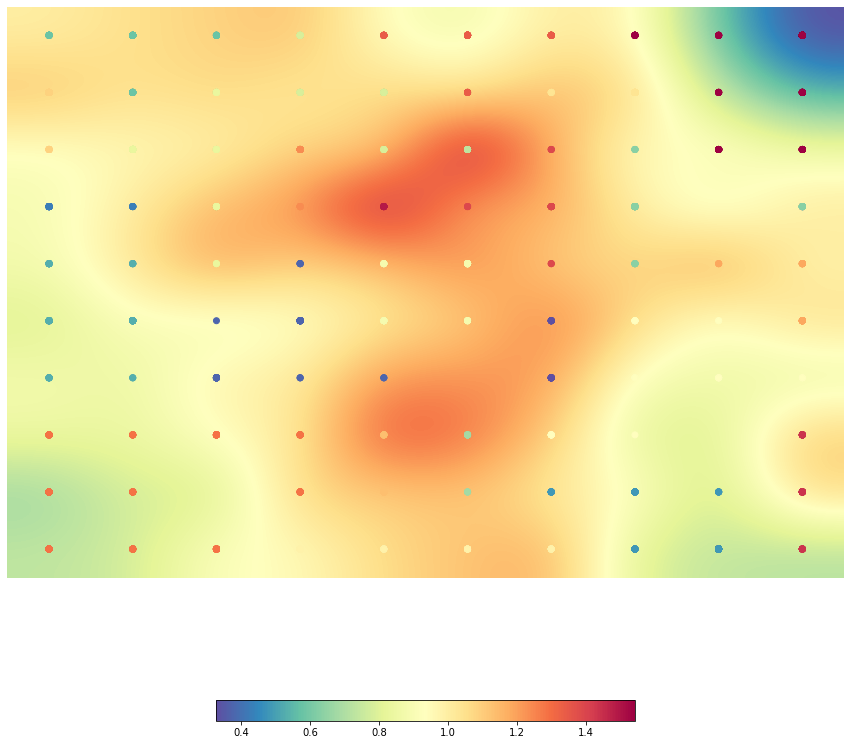

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [0]:
clusters = som.clusters
print(clusters)

[[ 5  5  5  9 20 20 20 24 24 24]
 [15  5 10  9  9 20 14 14 24 24]
 [15 10 10 18  9  8 21  6 24 24]
 [ 2  2 10 18 23 21 21  6  6  6]
 [ 4  4 10  1 11 11 21  6 17 17]
 [ 4  4  1  1 11 11  0 12 12 17]
 [ 4  4  1  1  1 12  0 12 12 12]
 [19 19 19 19 16  7 12 12 12 22]
 [19 19 19 19 16  7  3  3  3 22]
 [19 19 19 13 13 13 13  3  3 22]]


In [0]:
_, cl_unique = np.unique(clusters, return_counts = True)
cl_sorted = np.argsort(cl_unique)
print(cl_sorted)
print(cl_unique[cl_sorted])

[ 8 23  0  2 18 16 15  7 14 22 17 13 21 20  9  5 11  6  3 10  4  1 24 12
 19]
[ 1  1  2  2  2  2  2  2  2  3  3  4  4  4  4  4  4  5  5  5  6  6  7  9
 11]


## Semantic interpretation of the clusters

In order to evaluate the performance of our SOM model, we will print for each cluster the movie genres that correspond to it. If a cluster has a dominant category in it, which means that there are many more movies belonging to this category than the rest, then we can say that this cluster corresponds to that category.

In order to achieve this, we are going to implement the following functions:


1. Function `print_categories_stats`: This function takes as input a list of movie ids. Then it prints a count of movies belonging to each category. 

2. Function `print_cluster_neurons_movies_report`: This function takes as input a cluster id. Then it outputs a list of the best matching units that correspond to this cluster. 

3. Function `neuron_movies_report`: This function takes as input a list of neurons outputted by the `print_cluster_neurons_movies_report` function. Then using the `indices` array, creates a list that contains all the movies that correspond to those neurons. Finally, calls the `print_categories_stats` function to print the results.

Example of an output (from a default model):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [0]:
def print_categories_stats(ids):
  total_categories = []
  for id in ids:
    curr_categories = np.array2string(categories[id])[2:-2].split(',')
    curr_categories = [cat.strip().strip().strip('"') for cat in curr_categories]
    total_categories.extend(curr_categories)

  cat_names ,cat_count = np.unique(total_categories, return_counts = True)
  cat_sorted = np.argsort(cat_count)[::-1]

  for c in cat_sorted:
    print(cat_names[c] + " " + str(cat_count[c]))

In [0]:
def print_cluster_neurons_movies_report(cluster_id):
  j, i = np.where(clusters == cluster_id)
  idx = np.column_stack((i, j))
  
  total_bmus = []
  for bmu in idx:
    if bmu in ubmus:
        total_bmus.append(bmu)

  return list(total_bmus)


In [0]:
def neurons_movies_report(neurons):
  ind = []
  for i in range(len(bmus)):
    for neuron in neurons:
      if np.array_equal(bmus[i],neuron):
        ind.append(i)

  movies_ids = []
  for i in range(len(indices)):
    if indices[i] in ind:
      movies_ids.append(i)

  print_categories_stats(movies_ids)

In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(4))

Thriller 57
Psychological thriller 34
Mystery 33
Comedy 24
Crime Thriller 24
Crime Fiction 20
Suspense 17
Horror 15
Drama 14
Slapstick 10
Black comedy 9
Indie 9
Action 7
Adventure 7
Parody 7
World cinema 7
Black-and-white 6
Supernatural 6
Film adaptation 5
Film noir 4
Erotic thriller 3
Haunted House Film 3
Action/Adventure 3
Science Fiction 3
Detective 3
Detective fiction 3
Slasher 3
Comedy Thriller 2
Sports 2
Cult 2
Absurdism 2
Screwball comedy 2
Satire 2
Whodunit 1
Crime Comedy 1
Television movie 1
Action Thrillers 1
Political thriller 1
Teen 1
Adventure Comedy 1
Surrealism 1
Political drama 1
Neo-noir 1
Comedy film 1
Comedy of manners 1
Costume drama 1
Spy 1
Gross-out film 1
Musical comedy 1
Musical 1
Melodrama 1
Medical fiction 1
Domestic Comedy 1
Jukebox musical 1
Romance Film 1
Fantasy Comedy 1
Humour 1
Giallo 1
Gross out 1
Road movie 1


## Optimizing SOM

### 20x20 map

#### 20 clusters

In [0]:
som_20 = somoclu.Somoclu(20, 20, compactsupport=False)
%time som_20.train(final_set, epochs=100)

CPU times: user 10min 22s, sys: 982 ms, total: 10min 23s
Wall time: 5min 17s


In [0]:
joblib.dump(som_20, 'map_20.pkl')

['map_20.pkl']

In [0]:
som_20 = joblib.load('map_20.pkl')

In [0]:
bmus = som_20.bmus
print(bmus.shape)

(5000, 2)


In [0]:
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print(ubmus.shape)

(345, 2)


In [0]:
print(indices)

[306 108 127 ... 271 258 335]


In [0]:
algorithm = KMeans(n_clusters=20)
som_20.cluster(algorithm=algorithm)

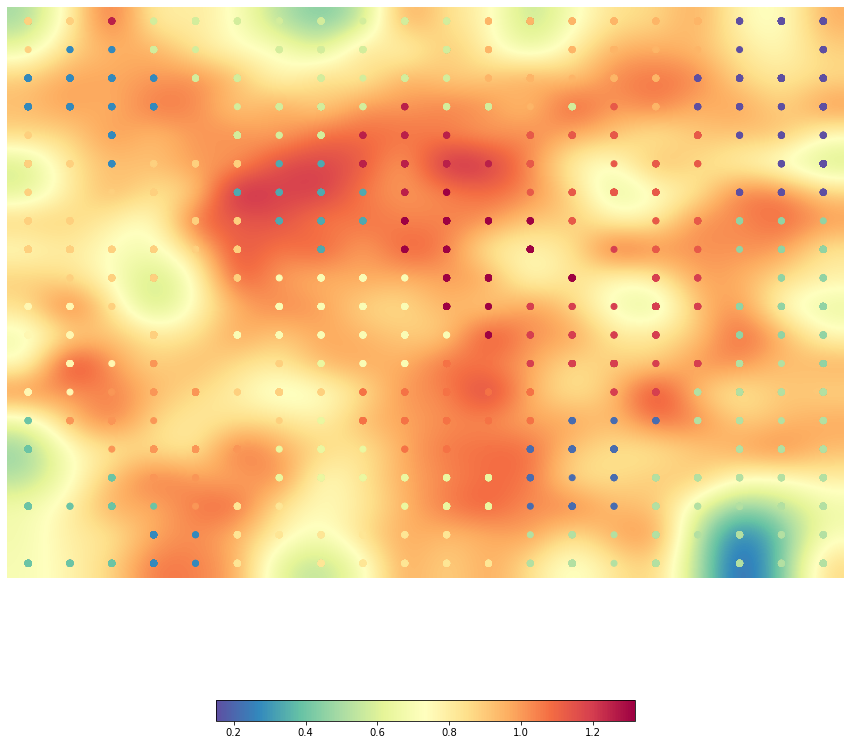

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
som_20.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [0]:
clusters = som_20.clusters
print(clusters)

[[12 12 18  7  7  7  7  7  7  7  7 13 13 13 13 13 13  0  0  0]
 [12  2  2  7  7  7  7  7  7  7  7 13 13 13 13 13 13  0  0  0]
 [ 2  2  2  2  7  7  7  7  7  7  7 13 13 13 13 13  0  0  0  0]
 [ 2  2  2  2  7  7  7  7  7 18  7  7 13  7 16 13  0  0  0  0]
 [12  2  2  2  7  7  7  7 18 18 18 16 16 16 16 16 16  0  0  0]
 [12 12  2 12 12 12  3  3 18 18 18 18 16 16 16 16 16  0  0  0]
 [12 12 12 12 12  3  3  3  3 18 19 19 16 16 16 16 16  0  0  0]
 [12 12 12 12 12 12  3  3  3 19 19 19 19 16 16 16 16  5  5  5]
 [12 12 12 12 12 12  3  3  9 19 19 19 19 19 17 16 16  5  5  5]
 [12 12 12 12 12 12  9  9  9  9 19 19 19 19 17 17 17  5  5  5]
 [10 10 12 12 12  9  9  9  9  9 19 19 17 17 17 17 17  5  5  5]
 [10 10 12 12 12  9  9  9  9  9  9 19 17 17 17 17 17  5  5  5]
 [10 10 10 14 14 12 12  8  9  9 15 15 17 17 17 17 17  6  6  5]
 [10 10 14 14 14 12 12 12 15 15 15 15 15 17 17 17  6  6  6  6]
 [ 4 14 14 14 14 14 12  8 15 15 15 15 15  1  1  1  6  6  6  6]
 [ 4  4 14 14 14 14  8  8  8 15 15 15  1  1  1  1  6  6

In [0]:
_, cl_unique = np.unique(clusters, return_counts = True)
cl_sorted = np.argsort(cl_unique)
print(cl_sorted)
print(cl_unique[cl_sorted])

[10 18  3  1 15  4  5 11  8  9 14 19  2 13 17 16  0  7  6 12]
[ 9 10 11 13 15 16 16 16 16 18 18 18 18 19 22 23 23 35 40 44]


In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(12))

Drama 207
Comedy 161
Romance Film 127
Romantic comedy 88
Horror 75
Science Fiction 75
Family Film 73
Crime Fiction 60
Indie 59
Action 54
Adventure 51
Thriller 50
Black-and-white 40
World cinema 40
Fantasy 28
Action/Adventure 26
Silent film 25
Short Film 25
Musical 20
Comedy film 20
Film adaptation 19
Biographical film 17
Period piece 17
Mystery 16
Family Drama 16
Parody 14
Satire 13
Romantic drama 13
Creature Film 13
Supernatural 13
Japanese Movies 12
Television movie 12
Sci-Fi Horror 12
B-movie 12
Cult 10
War film 10
Slapstick 10
Monster 10
Sports 9
Children\'s/Family 9
Natural horror films 9
Crime Thriller 9
Psychological thriller 8
Animation 8
Historical fiction 8
Alien Film 8
Fantasy Comedy 7
Documentary 7
Ensemble Film 7
Horror Comedy 7
Coming of age 7
Chinese Movies 7
Zombie Film 7
Political drama 7
Monster movie 6
Screwball comedy 5
Political cinema 5
Western 5
Docudrama 5
Martial Arts Film 5
Biography 5
History 5
Workplace Comedy 5
Action Thrillers 5
Biopic [feature] 4
Tragedy 

#### 25 clusters

In [0]:
algorithm = KMeans(n_clusters=25)
som_20.cluster(algorithm=algorithm)

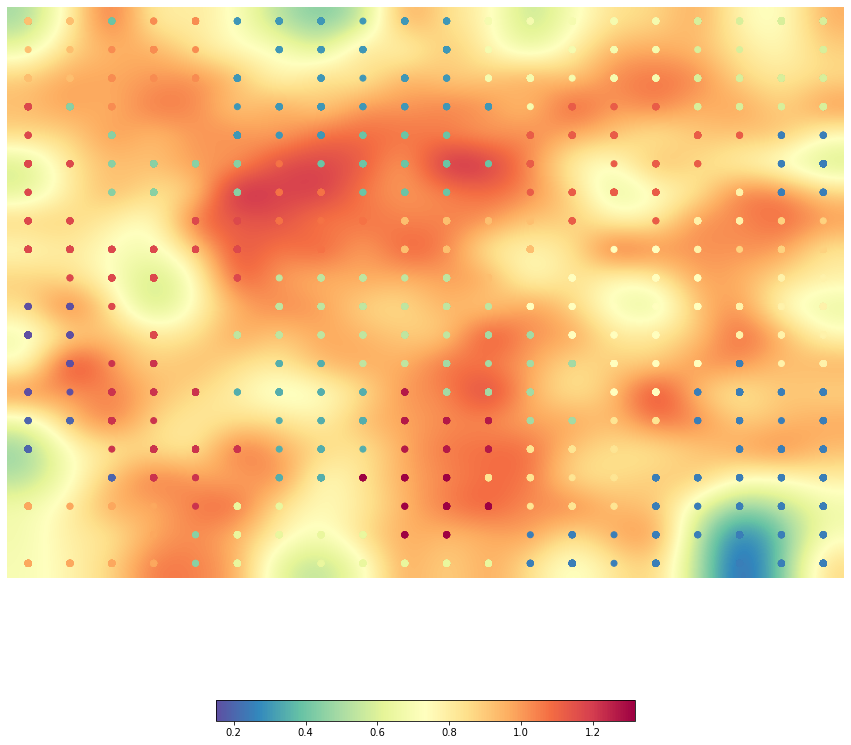

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
som_20.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [0]:
clusters = som_20.clusters
print(clusters)

[[16 16  5 18 18  3  3  3  3  3  3 11 11 11 11 11  9  9  9  9]
 [16 16 18 18 18  3  3  3  3  3  3 11 11 11 11 11  9  9  9  9]
 [16 16 18 18 18  3  3  3  3  3  3 11 11 11 11 11  9  9  9  9]
 [21  6 18 18 18  3  3  3  3  3  3  3 11 20 20 20  9  9  9  9]
 [21  6  6  6  6  3  3  3  5  5  5 20 20 20 20 20 20 20  2  2]
 [21 21  6  6  6  6 19  5  5  5  5  5 20 20 20 20 20  9  2  2]
 [21 21  6  6  6  6 19 19  5  5  5 16 20 20 20 20 20 13  2  2]
 [21 21 21 21 21 21 19 19 19 16 16 16 16 20 20 20 13 13 15 15]
 [21 21 21 21 21 21 19 19  8 16 16 16 16 16 12 12 13 15 15 15]
 [21 21 21 21 21 21  8  8  8  8  8 16 16 12 12 12 12 13 13 13]
 [ 0  0 21 21 21  8  8  8  8  8  8  8 12 12 12 12 12 13 13 13]
 [ 0  0 21 21 21  8  8  8  8  8  8  7  7 12 12 12 12 13 13 13]
 [ 0  0 22 22 22  4  4  4  8  8  7  7  7  7 12 12 12  2 13 13]
 [ 0  0 22 22 22  4  4  4  4 23  7  7  7  7 12 12  2  2  2  2]
 [ 1  1 22 22 22 22  4  4  4 23 23 23  7  7 14 14  2  2  2  2]
 [ 1  1 22 22 22 22  4  4  4 23 23 23 14 14 14 14  2  2

In [0]:
_, cl_unique = np.unique(clusters, return_counts = True)
cl_sorted = np.argsort(cl_unique)
print(cl_sorted)
print(cl_unique[cl_sorted])

[15  1 23  0 19 24 18  7  5 17 14 10  6  4 13 11  9 22 16 12  8 20  3 21
  2]
[ 5  7  7  8  8 10 11 12 12 12 13 14 15 15 15 16 17 18 18 20 21 23 28 30
 45]


In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(2))

Drama 444
Thriller 205
Horror 153
Indie 146
Black-and-white 126
Comedy 123
Romance Film 122
Action 120
Crime Fiction 106
Adventure 96
Action/Adventure 91
Romantic drama 79
World cinema 69
Comedy film 58
Film adaptation 57
Mystery 52
Science Fiction 50
Period piece 43
Crime Thriller 41
Comedy-drama 35
Family Film 33
Animation 32
Fantasy 31
Silent film 31
Short Film 29
War film 28
Melodrama 27
Film noir 27
Romantic comedy 27
Musical 26
Biographical film 26
Suspense 24
Biopic [feature] 24
Japanese Movies 23
Martial Arts Film 22
Teen 21
Western 21
Chinese Movies 21
Black comedy 21
Art film 20
Detective 19
Crime Drama 18
Detective fiction 18
Biography 18
Psychological thriller 16
Sports 16
Television movie 15
Political drama 14
Spy 14
Family Drama 14
Action Thrillers 13
Zombie Film 13
Horror Comedy 12
Coming of age 12
Children\'s 11
Historical fiction 11
Costume drama 11
Gangster Film 11
Cult 11
Superhero movie 10
Docudrama 10
Screwball comedy 10
B-movie 10
Bollywood 10
Buddy film 8
Parody 

### 25x25 map

#### 20 clusters

In [0]:
som_25 = somoclu.Somoclu(25, 25, compactsupport=False)
%time som_25.train(final_set, epochs=100)

CPU times: user 16min 24s, sys: 1.7 s, total: 16min 26s
Wall time: 8min 30s


In [0]:
joblib.dump(som_25, 'map_25.pkl') 

['map_25.pkl']

In [0]:
som_25 = joblib.load('map_25.pkl') 

In [0]:
bmus = som_25.bmus
print(bmus.shape)

(5000, 2)


In [0]:
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print(ubmus.shape[0])

509


In [0]:
print(indices)

[507  69  13 ... 152 408 352]


In [0]:
algorithm = KMeans(n_clusters=20)
som_25.cluster(algorithm=algorithm)

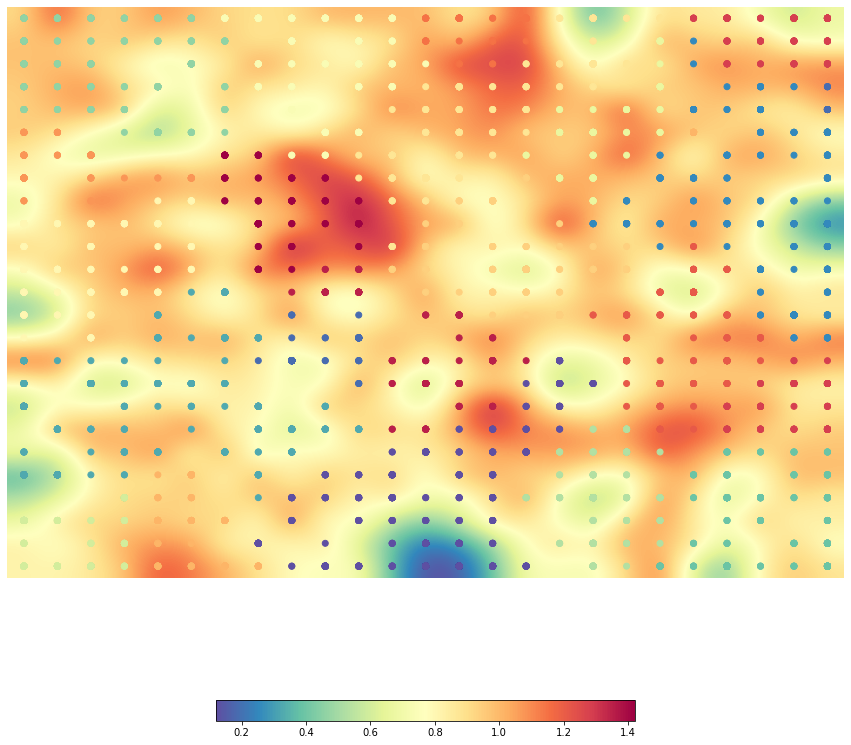

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
som_25.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [0]:
clusters = som_25.clusters
print(clusters)

[[ 5  5  5  5  5  5  9  9  9  9  9  9 15 15 15 15 11 11 11 11 17 17 17 17
  17]
 [ 5  5  5  5  5  5  5  9  9  9  9  9 15 15 15 15 11 11 11  8  2 17 17 17
  17]
 [ 5  5  5  5  5  5  5  9  9  9  9  9  9 15 15 11 11 11 11  8  2 17 17 17
  17]
 [ 5  5  5  5  5  5  5  9  9  9  9  9 11 11 11 11 11 11  8  8  2  2  2  2
   1]
 [ 5  5  5  5  5  5  5  9  9  9  9 11 11 11 11 11  8  8  8  8  2  2  2  2
   1]
 [14 14 14  5  5  5  5  9  9  9  9 11 11 11 11 11  8  8  8  8 13  2  2  2
   2]
 [14 14 14 14  5 14 19 19  9  9 11 11 11 11 11  8  8  8  8  2  2  2  2  2
   2]
 [14 14 14 14 14 14 19 19 19 19 11 11 11 11 12 12  8  8  8  2  2  2  2  2
   2]
 [14 10 14 10 10 10 19 19 19 19 19 11 11 12 12 12  8  8  2  2  2  2  2  2
   2]
 [10 10 10 10 10 10 19 19 19 19 19 19 12 12 12 12 12  2  2  2  2  2  2  2
   2]
 [10 10 10 10 10 10 19 19 19 19 19 11 12 12 12 12 12 12 12  2 16  2  2  2
   2]
 [10 10 10 10 10 10  3 19 19 18 18 12 12 12 12 12 12 12 12 16 16 16  2  2
   2]
 [10 10 10 10 10  3  3  3 18 18 18 18 12

In [0]:
_, cl_unique = np.unique(clusters, return_counts = True)
cl_sorted = np.argsort(cl_unique)
print(cl_sorted)
print(cl_unique[cl_sorted])

[15 14  7  1 13  8 19 17  6 18  4  9 12 10 16  5 11  2  0  3]
[10 16 16 17 17 21 24 26 26 27 31 32 34 34 34 39 39 57 57 68]


In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(3))

Drama 257
Comedy 177
Thriller 114
Action 99
Crime Fiction 83
Horror 82
World cinema 70
Action/Adventure 67
Indie 61
Science Fiction 51
Black-and-white 45
Adventure 44
Comedy film 42
Crime Thriller 31
Martial Arts Film 28
Mystery 26
Chinese Movies 25
Biographical film 24
Bollywood 24
Slasher 22
Psychological thriller 18
Western 17
B-movie 17
Fantasy 16
Musical 16
Creature Film 16
Family Film 14
Teen 13
Slapstick 12
Monster movie 11
Supernatural 11
Crime Drama 10
Natural horror films 10
Gangster Film 9
Romance Film 9
Coming of age 9
War film 9
Black comedy 9
Sports 9
Biography 9
Film adaptation 8
Monster 8
Wuxia 8
Biopic [feature] 8
Cult 8
Film noir 8
Political thriller 8
Period piece 7
Romantic comedy 7
Suspense 7
Satire 7
Political drama 6
Japanese Movies 6
Action Comedy 6
Television movie 6
Historical fiction 6
History 5
Docudrama 5
Parody 5
Jungle Film 4
Animation 4
Spy 4
Action Thrillers 4
Documentary 4
Ensemble Film 4
Melodrama 4
Fantasy Adventure 3
Adventure Comedy 3
Doomsday film

#### 25 clusters

In [0]:
algorithm = KMeans(n_clusters=25)
som_25.cluster(algorithm=algorithm)

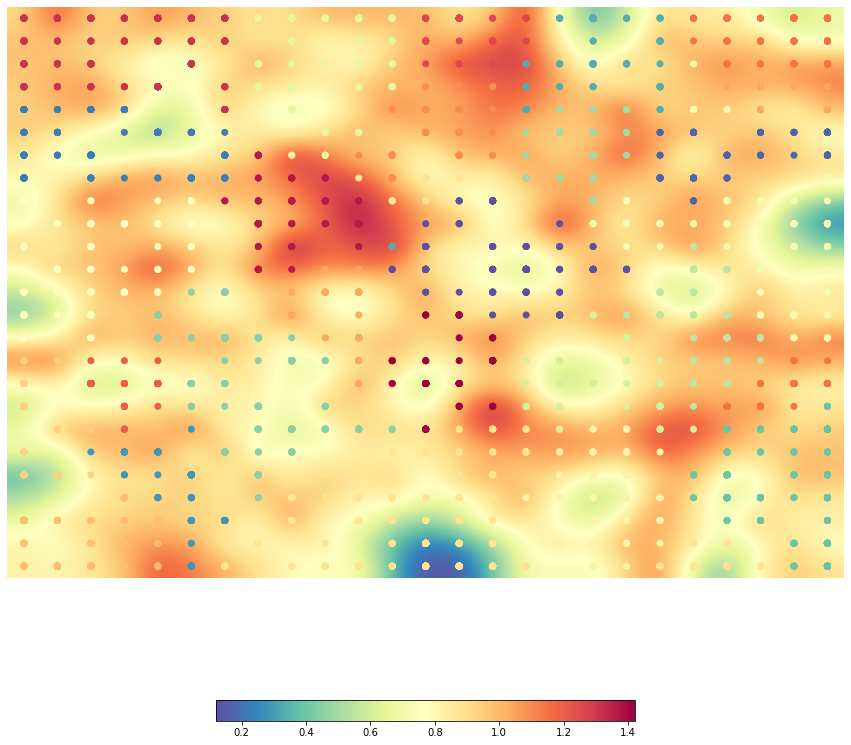

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
som_25.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [0]:
clusters = som_25.clusters
print(clusters)

[[22 22 22 22 22 22 22 10 10 10 10 10 21 21 21 21  4  4  4  4 19 19 19 19
  19]
 [22 22 22 22 22 22 22 10 10 10 10 10 21 21 21 21  4  4  4  4 19 19 19 19
  19]
 [22 22 22 22 22 22 22 10 10 10 10 10 21 21 21  4  4  4  4  4 11 19 19 19
  19]
 [22 22 22 22 22 22 22 10 10 10 10 10 18 18 18  4  4  4  4  4 11 17 17 17
  17]
 [ 2  2  2  2  2  2 22 10 10 10 10 18 18 18 18  4  7  7  7  4 11 11 17 17
  17]
 [ 2  2  2  2  2  2  2 10 10 10 10 18 18 18 18  7  7  7  7  1  1  1  1  1
   1]
 [ 2  2  2  2  2  2  2 23 10 10 18 18 18 18 18  7  7  7  7  1  1  1  1  1
   1]
 [ 2  2  2  2  2  2  2 23 23 23 14 18 14 14  0  7  7  7  7  1  1  1  1 11
  11]
 [12 12 12 12 12 12 23 23 23 23 23 14 14  0  0  0  7  7 11  1  1 11 11 11
  11]
 [12 12 12 12 12 12 23 23 23 23 23 23  0  0  0  0  0 11 11 11 11 11 11 11
  11]
 [12 12 12 12 12 12 12 23 23 23 23  4  0  0  0  0  0  0 11 11  8 11 11 11
  11]
 [12 12 12 12 12 12  6 23 23 17 17  0  0  0  0  0  0  0  0  8  8  8 11 11
  11]
 [12 12 12 12 12  6  6  6 17 17 17 17  0

In [0]:
_, cl_unique = np.unique(clusters, return_counts = True)
cl_sorted = np.argsort(cl_unique)
print(cl_sorted)
print(cl_unique[cl_sorted])

[20 21 15  3 16  7 18  1 24  4 23 17  9  8 19 13  2 22  5 10  0 11 12  6
 14]
[11 11 15 16 17 17 17 18 19 21 21 22 22 22 22 26 27 29 30 30 32 36 37 44
 63]


In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(14))

Drama 648
Comedy 250
Romance Film 207
Thriller 134
Action 134
World cinema 132
Romantic drama 116
Action/Adventure 115
Indie 109
Short Film 104
Adventure 101
Black-and-white 93
Family Film 92
Animation 88
Musical 74
Crime Fiction 71
Documentary 67
Film adaptation 67
Romantic comedy 65
Horror 63
Period piece 56
Science Fiction 47
Western 43
Fantasy 43
Mystery 34
Art film 33
Comedy-drama 31
War film 30
Bollywood 28
Suspense 28
Silent film 28
Family Drama 26
Costume drama 24
Biography 22
Biographical film 21
Psychological thriller 21
Teen 20
Children\'s/Family 20
Coming of age 20
Biopic [feature] 19
Sports 18
Television movie 16
Zombie Film 15
Supernatural 15
Children\'s 14
Crime Thriller 14
History 14
Comedy film 14
Political drama 14
Chinese Movies 13
Black comedy 13
Slapstick 12
Satire 12
Action Thrillers 11
Crime Drama 11
Film noir 10
Docudrama 10
Buddy film 10
Japanese Movies 10
Melodrama 10
Epic 10
Creature Film 9
Family-Oriented Adventure 9
Ensemble Film 9
Cult 9
Superhero movie 9


#### 30 clusters

In [0]:
algorithm = KMeans(n_clusters=30)
som_25.cluster(algorithm=algorithm)

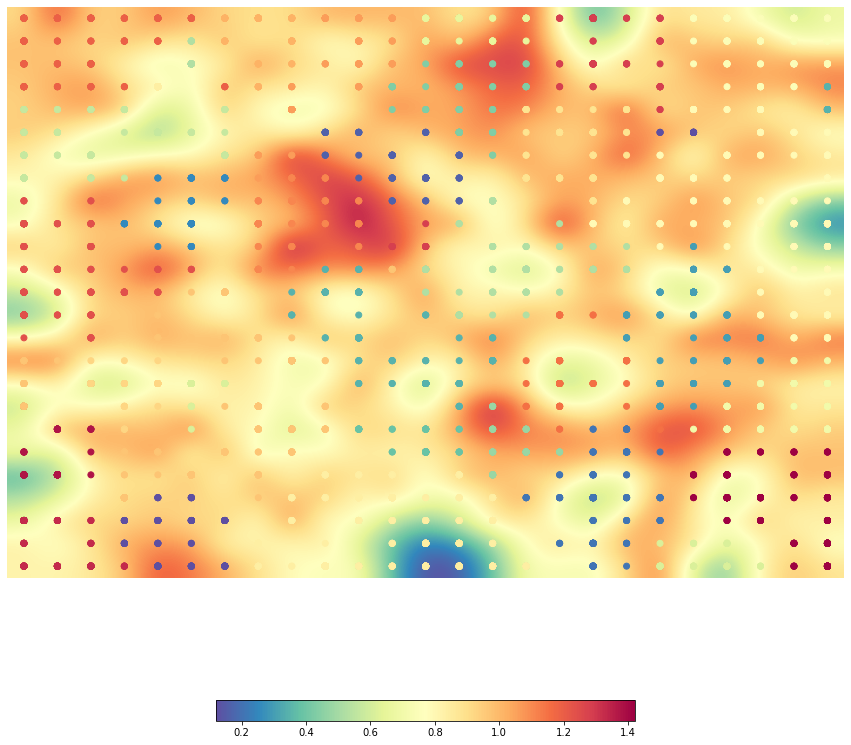

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
som_25.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [0]:
clusters = som_25.clusters
print(clusters)

[[24 24 24 24 24 24 20 20 20 21 21 21 12 12 12 12 26 26 26 26 14 14 14 14
  14]
 [24 24 24 24 24  9 20 20 20 21 21 21 12 12 12 12 26 26 26 26 14 14 14 14
  14]
 [24 24 24 24 24  9 20 20 20 21 21 21  7  7  7  7 26 26 26 26 14 14 14 14
  14]
 [24 24 24 24 16 24 24 20 21 21 21  7  7  7  7  7 26 26 26 26 15 14 14 14
   5]
 [10 10 10 10 10 10 10 21 21 21 21  7  7  7  7 17 17 17 17 26 15 15 15 15
   5]
 [10 10 10 10 10 10 10 21 21  1  1  1  1  7  7 17 17 17 17  0  0 15 15 15
  15]
 [10 10 10 10 10 10 10 21 21  1  1  1  1  1  7 17 17 17 17 15 15 15 15 15
  15]
 [10 10 10 10  3  3  3 21 22 22  1  1  1  1  1 17 17 17 17 15 15 15 15 15
  15]
 [25 25 25  3  3  3  3 22 22 22 22  1  1  1  9  9 17 17 15 15 15 15 15 15
  15]
 [25 25 25  3  3  3  3 22 22 22 22 22 26  9  9  9  9 15 15 15 15 15 15 15
  15]
 [25 25 25 25  3  3  3 22 22 22 22 26 26  9  9  9  9  9  9 15  4 15 15 15
  15]
 [25 25 25 25 25 25 19 22 22  5  5 19  9  9  9  9  9  9  9  4  4  4 15 15
  15]
 [25 25 25 25 25 19 19 19  5  5  5  5  9

In [0]:
_, cl_unique = np.unique(clusters, return_counts = True)
cl_sorted = np.argsort(cl_unique)
print(cl_sorted)
print(cl_unique[cl_sorted])

[ 8 12  6 27 20 28 18  3 11 13  0  7  1 22 17 14 23 26 21 24 29  2 10  4
 25  9  5 16 15 19]
[ 8  8  9 10 10 10 11 14 14 14 16 16 17 17 18 18 19 20 21 22 23 24 25 26
 28 30 32 39 52 54]


In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(19))

Drama 236
Comedy 148
Action 85
Thriller 85
World cinema 78
Crime Fiction 62
Bollywood 46
Black-and-white 43
Comedy film 42
Action/Adventure 42
Horror 40
Musical 39
Indie 31
Period piece 28
Martial Arts Film 26
Chinese Movies 24
Slasher 21
Fantasy 20
Mystery 18
War film 17
Biographical film 15
Western 14
Adventure 14
Romance Film 13
Science Fiction 13
Crime Thriller 12
Slapstick 12
Political drama 11
Psychological thriller 11
B-movie 10
Creature Film 9
History 9
Wuxia 8
Sports 7
Teen 7
Crime Drama 6
Romantic drama 6
Biography 6
Coming of age 5
Japanese Movies 5
Action Comedy 5
Historical fiction 5
Art film 5
Black comedy 5
Cult 5
Natural horror films 5
Animation 4
Supernatural 4
Television movie 4
Film adaptation 4
Political thriller 4
Spy 4
Propaganda film 4
Jungle Film 4
Gangster Film 4
Romantic comedy 4
Fantasy Adventure 3
Family Film 3
Courtroom Drama 3
Ensemble Film 3
Monster 3
Docudrama 3
Music 3
Parody 3
Biopic [feature] 3
Anime 3
Film noir 3
Epic 2
Documentary 2
Erotic thriller 

## Evaluating SOM results

After choosing the optimal SOM model for our dataset, we will evaluate its performance based on the clusters it created and the following criteria: 

1. Data with high probability density function values in regard to the input space tend to correspond to more neurons in the reducted dimensionality space. We will give examples of frequent and less frequent categories of movies.
2. Distant input examples tend to correspond to distant neurons in the map. We will give such examples below.
3. Close input examples tend to correspond to close neurons in the map. We will give such examples below.
4. We will show big and small clusters with unclear characteristics, and we will interpret those results. 
5. Clusters with specific movie categories that don't have a topological relevance to the areas around them.


As our final SOM model we choose the one we created with map size 25*25 and 25 clusters. 

In [0]:
som = joblib.load('map_25.pkl')

In [0]:
bmus = som.bmus
print(bmus.shape)

(5000, 2)


In [0]:
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print(ubmus.shape)

(509, 2)


In [0]:
print(indices)

[507  69  13 ... 152 408 352]


In [0]:
algorithm = KMeans(n_clusters=25)
som.cluster(algorithm=algorithm)

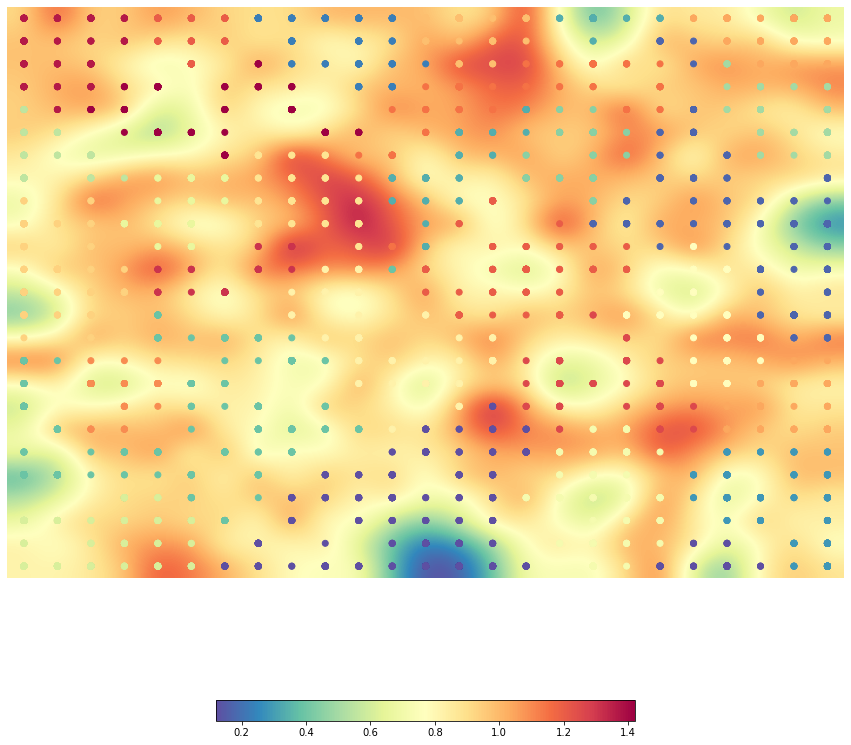

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [0]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15))

In [0]:
clusters = som.clusters
print(clusters)

[[23 23 23 23 20 20 20  2  2  2  2  2 16 16 16 16  4  4  4  4 17 17 17 17
  17]
 [23 23 23 23 20 20 20  2  2  2  2  2 16 16 16 16  4  4  4  1  1 17 17 17
  17]
 [23 23 23 23 24 20 24 24  2  2  2  2  2 16 16 19 19 19 19 19  1  7 17 17
  17]
 [23 23 23 24 24 24 24 24 24  2  2  2 19 19 19 19 19 19 19 19  1  7  7  7
   7]
 [ 8 23 24 24 24 24 24 24 24 24  2 19 19 19 19  4  6  6 19 19  1  7  7  7
   7]
 [ 8  8  8 24 24 24 24 24 24 24 24 19 19  4  4  4  6  6  6  1  1  1  7  7
   7]
 [ 8  8  8  8 24 24 24 14 14 14 19 19  4  4  4  6  6  6  6  1  1  1  7  7
   7]
 [ 8  8  8  8 10 10 10 14 14 14 14  4  4  4  4  6  6  6  6  1  1  1  1  1
   1]
 [15 15 15 10 10 10 10 14 14 14 14  4  4  4 20 20  6  6  1  1  1  1  1  1
   1]
 [15 15 15 10 10 10 10 14 14 14 14 14  4 20 20 20 20  1  1  1  1  1  1  1
   1]
 [15 15 15 15 10 10 10 22 22 14 14 19  4 20 20 20 20 20 20  1 12  1  1  1
   1]
 [15 15 15 15 22 22 22 22 22 13 13  5 20 20 20 20 20 20 20 12 12 12  1  1
   1]
 [15 15 15 15 22 22 22 22 13 13 13 13 20

In [0]:
_, cl_unique = np.unique(clusters, return_counts = True)
cl_sorted = np.argsort(cl_unique)
print(cl_sorted)
print(cl_unique[cl_sorted])

[16 22 18  8 10  6  7 23 14  2 12  9  4 21 19 15  3 17 11 24 13 20  1  0
  5]
[10 11 12 12 14 15 15 16 18 19 21 21 23 24 24 25 25 25 26 28 31 36 48 60
 66]


We then save the final SOM model after clustering.

In [0]:
joblib.dump(som, 'som.pkl') 

['som.pkl']

### Examples of frequent and less frequent movie categories.

In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(5))

Drama 300
Action 113
World cinema 86
Comedy 82
Thriller 76
Crime Fiction 75
Action/Adventure 64
Indie 54
Bollywood 45
Musical 42
Comedy film 42
Adventure 40
Black-and-white 40
Romance Film 39
Period piece 31
Crime Thriller 30
Martial Arts Film 28
Horror 27
Biographical film 26
Chinese Movies 25
Fantasy 23
Science Fiction 23
War film 22
Coming of age 17
Mystery 16
Psychological thriller 15
Family Film 15
Creature Film 13
Film adaptation 13
Western 12
Slapstick 12
Sports 12
Political drama 12
History 10
Biography 10
B-movie 9
Political thriller 9
Wuxia 8
Japanese Movies 8
Biopic [feature] 8
Gangster Film 8
Teen 7
Historical fiction 7
Docudrama 6
Romantic comedy 6
Crime Drama 6
Satire 6
Film noir 6
Romantic drama 6
Suspense 6
Natural horror films 6
Action Comedy 5
Art film 5
Black comedy 5
Monster movie 5
Television movie 5
Spy 4
Animation 4
Supernatural 4
Monster 4
Action Thrillers 4
Comedy-drama 3
Fantasy Adventure 3
Propaganda film 3
Prison 3
Swashbuckler films 3
Family Drama 3
Parody 

In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(0))

Drama 612
Comedy 216
Romance Film 182
Thriller 136
Action 132
World cinema 131
Indie 108
Action/Adventure 108
Romantic drama 93
Black-and-white 89
Adventure 83
Short Film 72
Musical 70
Crime Fiction 68
Romantic comedy 65
Horror 64
Animation 53
Film adaptation 49
Science Fiction 45
Fantasy 40
Family Film 39
Western 38
Mystery 34
Art film 33
Comedy-drama 31
Period piece 29
Bollywood 28
Silent film 28
Suspense 27
War film 23
Psychological thriller 21
Teen 20
Coming of age 19
Biography 18
Family Drama 18
Sports 17
Biopic [feature] 16
Zombie Film 15
Supernatural 15
Children\'s/Family 15
Biographical film 15
Comedy film 14
Crime Thriller 14
Chinese Movies 14
Black comedy 13
Political drama 13
Children\'s 13
Costume drama 13
Crime Drama 12
Slapstick 12
Action Thrillers 12
Satire 12
Buddy film 11
Japanese Movies 11
Film noir 10
Docudrama 10
Television movie 10
Creature Film 9
Ensemble Film 9
Cult 9
Superhero movie 8
Martial Arts Film 8
History 8
Melodrama 8
Spy 7
Parody 7
Musical comedy 7
Disa

In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(1))

Drama 64
Thriller 53
Silent film 41
Action 40
Comedy 36
World cinema 35
Romance Film 25
Fantasy 24
Action/Adventure 21
Family Film 19
Adventure 18
Western 15
Crime Fiction 15
Crime Thriller 14
Indie 12
Science Fiction 10
Romantic drama 10
Martial Arts Film 9
Television movie 9
Chinese Movies 9
Romantic comedy 8
Black-and-white 8
War film 7
Children\'s/Family 7
Bollywood 6
Psychological thriller 6
Period piece 6
Family Drama 5
Japanese Movies 5
Mystery 5
Political drama 5
Musical 4
Film adaptation 4
Gangster Film 4
Biographical film 4
Holiday Film 4
Musical Drama 3
Horror 3
Comedy-drama 3
History 3
Historical fiction 3
Action Thrillers 3
Coming of age 3
Fantasy Comedy 2
Biopic [feature] 2
Crime Drama 2
Comedy film 2
Art film 2
Family-Oriented Adventure 2
Costume drama 2
Christmas movie 2
Fantasy Drama 2
Political thriller 2
Short Film 2
Suspense 2
Surrealism 2
Music 2
Superhero movie 2
Melodrama 2
Spy 2
Slapstick 2
Medical fiction 2
Chase Movie 1
Time travel 1
Children\'s Fantasy 1
Chil

As we can see, the "Drama" category, which has a high probability density value in regard to the input space, is the most common category at the top 3 of the biggest clusters. In addition, categories such as "Thriller", "Comedy" and "Action" which are also common in our dataset, correspond to many neurons in different clusters. On the other hand, the less frequent categories such as "Christian Film", "Heist" and so on, appear in very few clusters with few neurons.

### Distant input examples that correspond to distant neurons in the map

In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(16))

Japanese Movies 40
Comedy 18
Short Film 12
Thriller 11
Crime Fiction 10
Martial Arts Film 8
Drama 8
Action 8
Action/Adventure 8
Anime 5
Silent film 4
Indie 4
Mystery 4
Romance Film 3
Black-and-white 3
Action Thrillers 3
Adventure 2
Sports 2
Gangster Film 2
Horror 2
Animation 2
Auto racing 1
Buddy film 1
Caper story 1
Chase Movie 1
War film 1
Comedy film 1
Computer Animation 1
Crime Drama 1
Documentary 1
Film noir 1
Heist 1
Musical 1
Period piece 1
Science Fiction 1
Slasher 1
Fantasy 1


In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(9))

Drama 123
Crime Fiction 73
Action 67
Horror 55
Thriller 50
Short Film 42
Adventure 38
Romance Film 37
Comedy 37
Action/Adventure 36
Indie 26
Romantic drama 24
Mystery 24
Crime Thriller 20
Family Film 16
Fantasy 16
Black-and-white 16
Comedy-drama 12
Animation 12
Gangster Film 10
Japanese Movies 10
Romantic comedy 10
Period piece 9
Action Thrillers 9
Musical 9
Film adaptation 9
Silent film 8
Science Fiction 8
Suspense 8
Slapstick 7
Parody 7
Family Drama 6
War film 6
Coming of age 6
Crime Drama 6
Music 5
Martial Arts Film 5
Spy 5
World cinema 5
Comedy film 5
Political thriller 4
Political drama 4
Sports 4
Television movie 4
Blaxploitation 4
Melodrama 3
Cult 3
Film noir 3
Black comedy 3
Satire 3
Biography 3
Biographical film 3
Psychological thriller 3
Musical Drama 2
Dystopia 2
Erotic thriller 2
Sci Fi Pictures original films 2
Ensemble Film 2
Comedy of manners 2
Domestic Comedy 2
Fantasy Adventure 2
Disaster 2
Superhero movie 2
Teen 2
Remake 2
Auto racing 2
Costume Adventure 2
Boxing 2
Bi

As we can see, the clusters with ids 16 and 9 that correspond to distant neurons in the map, come from distant input examples.


### Close input examples tend to correspond to close neurons in the map.

In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(13))

Drama 50
Comedy film 44
Romance Film 44
Comedy 33
Family Film 30
Animation 28
Short Film 27
Musical 16
Period piece 15
Chinese Movies 15
Black comedy 13
Indie 13
Romantic drama 12
War film 9
Coming of age 8
Teen 8
Cult 8
World cinema 8
Comedy-drama 7
Horror 6
Martial Arts Film 6
Thriller 5
Romantic comedy 5
Screwball comedy 5
Black-and-white 5
Western 4
Wuxia 4
Sports 4
Action/Adventure 4
Domestic Comedy 3
Family Drama 3
Historical fiction 3
Supernatural 3
Science Fiction 3
Mystery 3
Biography 2
Comedy of Errors 2
Adventure 2
Crime Fiction 2
Melodrama 2
Comedy Thriller 2
Buddy film 1
Anti-war 1
Anti-war film 1
Bollywood 1
Christian film 1
Blaxploitation 1
Biographical film 1
Addiction Drama 1
Children\'s/Family 1
Zombie Film 1
Comedy of manners 1
Costume Horror 1
Television movie 1
Suspense 1
Spy 1
Sex comedy 1
Satire 1
Musical Drama 1
Music 1
History 1
Gangster Film 1
Fantasy 1
Escape Film 1
Ensemble Film 1
Docudrama 1
Dance 1
Courtroom Drama 1
Action 1


In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(21))

Drama 55
Comedy 42
World cinema 36
Romance Film 32
Short Film 25
Romantic comedy 25
Romantic drama 25
Action 23
Adventure 18
Documentary 17
Action/Adventure 16
Children\'s/Family 14
Fantasy 12
Musical 12
Family Film 8
Thriller 8
Children\'s Fantasy 7
Bollywood 7
Science Fiction 6
Black comedy 6
War film 6
Comedy film 5
Martial Arts Film 5
Teen 4
Indie 4
Fan film 4
Sports 4
Horror 4
Black-and-white 3
Art film 3
Epic 3
Action Thrillers 3
Film adaptation 3
Fantasy Adventure 3
Courtroom Drama 2
Historical fiction 2
Political drama 2
B-movie 2
Medical fiction 2
Sex comedy 2
Chinese Movies 2
Ensemble Film 2
Remake 1
Computer Animation 1
Coming of age 1
Comedy-drama 1
Political cinema 1
Clay animation 1
Christmas movie 1
Propaganda film 1
Japanese Movies 1
Children\'s 1
Costume drama 1
Romantic fantasy 1
Biography 1
Swashbuckler films 1
Animal Picture 1
Alien Film 1
Silent film 1
Slapstick 1
Slice of life story 1
Tollywood 1
Crime Comedy 1
Jungle Film 1
Spy 1
Horror Comedy 1
Language & Litera

As we can see, both of the clusters above, that correspond to close neurons in the map, have many commedy and drama movies.

### Clusters with unclear characteristics

In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(4))

Comedy 67
Documentary 66
Thriller 56
Drama 55
Family Film 54
Animation 37
Action/Adventure 37
Short Film 34
Horror 33
Period piece 31
Romance Film 31
Action 30
Black-and-white 30
Film adaptation 28
Romantic drama 24
Adventure 23
Indie 17
Costume drama 12
Western 11
War film 10
Science Fiction 8
World cinema 8
Family Drama 8
Action Thrillers 8
Fantasy 8
Biographical film 7
Crime Fiction 7
History 6
Television movie 6
Children\'s 6
Film noir 5
Children\'s/Family 5
Musical 5
Mystery 5
Screwball comedy 4
Parody 4
Filipino Movies 4
Disaster 4
Historical drama 4
Epic 4
Biopic [feature] 4
Biography 4
Sports 3
Coming of age 3
Monster movie 3
Historical fiction 3
Japanese Movies 3
Spy 3
Family-Oriented Adventure 3
Experimental film 2
Black comedy 2
Surrealism 2
Detective fiction 2
Detective 2
Silent film 2
Political drama 2
Christian film 2
Melodrama 2
Bollywood 2
Propaganda film 2
Childhood Drama 2
Psychological thriller 2
Whodunit 2
Music 2
Avant-garde 2
Auto racing 2
Satire 2
Chinese Movies 

As we can see, the dominant categories are distant in regard to their semantics. Therefore, the cluster doesn't have a clear content.

### Clusters with specific movie categories that don't have a topological relevance to the areas around them

In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(5))

Drama 300
Action 113
World cinema 86
Comedy 82
Thriller 76
Crime Fiction 75
Action/Adventure 64
Indie 54
Bollywood 45
Musical 42
Comedy film 42
Adventure 40
Black-and-white 40
Romance Film 39
Period piece 31
Crime Thriller 30
Martial Arts Film 28
Horror 27
Biographical film 26
Chinese Movies 25
Fantasy 23
Science Fiction 23
War film 22
Coming of age 17
Mystery 16
Psychological thriller 15
Family Film 15
Creature Film 13
Film adaptation 13
Western 12
Slapstick 12
Sports 12
Political drama 12
History 10
Biography 10
B-movie 9
Political thriller 9
Wuxia 8
Japanese Movies 8
Biopic [feature] 8
Gangster Film 8
Teen 7
Historical fiction 7
Docudrama 6
Romantic comedy 6
Crime Drama 6
Satire 6
Film noir 6
Romantic drama 6
Suspense 6
Natural horror films 6
Action Comedy 5
Art film 5
Black comedy 5
Monster movie 5
Television movie 5
Spy 4
Animation 4
Supernatural 4
Monster 4
Action Thrillers 4
Comedy-drama 3
Fantasy Adventure 3
Propaganda film 3
Prison 3
Swashbuckler films 3
Family Drama 3
Parody 

In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(22))

Comedy 124
Thriller 41
Drama 30
Horror 21
Slasher 20
Parody 10
Mystery 8
Adventure 6
Black-and-white 6
Indie 5
Crime Fiction 5
Teen 4
Film adaptation 4
Black comedy 4
Western 4
Cult 4
Ensemble Film 3
Jungle Film 3
Psychological thriller 3
Comedy-drama 2
Comedy film 2
Mockumentary 2
Action 2
Political cinema 2
Satire 2
Whodunit 2
Action/Adventure 2
Political drama 2
Comedy Western 1
Biography 1
B-movie 1
Animation 1
Christmas movie 1
Animal Picture 1
Americana 1
Courtroom Drama 1
Adventure Comedy 1
Bollywood 1
Crime Drama 1
Action Comedy 1
Crime Thriller 1
Comedy of manners 1
Zombie Film 1
Dystopia 1
Ealing Comedies 1
Travel 1
Tollywood 1
Supernatural 1
Stoner film 1
Stand-up comedy 1
Spy 1
Social problem film 1
Short Film 1
Road movie 1
Remake 1
Religious Film 1
Propaganda film 1
Outlaw biker film 1
Music 1
Melodrama 1
Media Satire 1
Workplace Comedy 1
Holiday Film 1
Giallo 1
Horror Comedy 1


The clusters above are close. However, their dominant categories are not relevant.

Possible causes for the above results:

- The information we lose by going to a two dimensional map.

- The information we lose by reducing the dimensions of our tf_idf vectorizer.

- The common drawbacks of using a TFIDF representation.

- The fact that sometimes the relevance between two movie genres is not clear or absolute, even for humans.

- The fact that the dataset is unbalanced.

- Some categories are so close, or pretty much the same. (i.g., Comedy - Comedy Film, Romance Film - Romantic Drama)

### Interesting clusters

In [0]:
neurons_movies_report(print_cluster_neurons_movies_report(16))

Japanese Movies 40
Comedy 18
Short Film 12
Thriller 11
Crime Fiction 10
Martial Arts Film 8
Drama 8
Action 8
Action/Adventure 8
Anime 5
Silent film 4
Indie 4
Mystery 4
Romance Film 3
Black-and-white 3
Action Thrillers 3
Adventure 2
Sports 2
Gangster Film 2
Horror 2
Animation 2
Auto racing 1
Buddy film 1
Caper story 1
Chase Movie 1
War film 1
Comedy film 1
Computer Animation 1
Crime Drama 1
Documentary 1
Film noir 1
Heist 1
Musical 1
Period piece 1
Science Fiction 1
Slasher 1
Fantasy 1


The cluster above includes many Japanese movies despite the fact that there aren't many of those films in our dataset.